# Using Data Science to understand the Hollywood Gender Gap

### Imports

In [232]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [100]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [101]:
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from turicreate import SFrame
import turicreate.aggregate as agg

In [102]:
import numpy as np

In [103]:
from subs2graph.consts import TEMP_PATH, DATA_PATH

## Introduction

In the past couple of years we have heard many stories about women discrimination is the film industry.
Even worse there was many reports of women sexual harassments in Hollywood which has led to the rise of the MeToo Movement.
This paper, investigates the gender gap in Hollywood utilizing data science techniques. 

## File Genartion

In [343]:
from subs2graph.videos_sn_creator import generate_actors_file
generate_actors_file()

KeyboardInterrupt: 

## Analysis


<img src="https://i.kym-cdn.com/entries/icons/mobile/000/027/456/kowalski.jpg" />


In [344]:
from subs2graph.graph_analyzer import *

### Load actors-movies list

In [347]:
actors = pd.read_csv(f"{TEMP_PATH}/actors.csv",index_col=0 )
actors = actors.drop(["endYear", "isAdult", "knownForTitles", "originalTitle", "titleType"], axis=1)

[autoreload of tqdm._tqdm failed: Traceback (most recent call last):
  File "/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/dimakagan

In [349]:
len(actors["nconst"].unique())

3667

In [350]:
len(actors["tconst"].unique())

13055

In [351]:
len(actors[actors["gender"]=="F"]["nconst"].unique())

1294

In [352]:
actors.head(1)

,averageRating,birthYear,birthYear.1,characters,count,deathYear,deathYear.1,gender,gender.1,genres,...,nconst,path,primaryName,primaryName.1,primaryProfession,primaryProfession.1,primaryTitle,runtimeMinutes,startYear,tconst
0,7.042857,1899,1899.0,['Guy Holden'],28,1987,1987.0,M,M,"Comedy,Musical,Romance",...,nm0000001,/Users/dimakagan/Projects/subs2graph/temp/movi...,Fred Astaire,Fred Astaire,"soundtrack,actor,miscellaneous",actor,The Gay Divorcee,107.0,1934.0,tt0025164


### Join with movies meta data

In [353]:
def analyze_actors():
    p = f"{TEMP_PATH}/movies/"
    res = []
    for i, a in tqdm(actors.iterrows()):
        g_pth = a["path"]
        try:
            with open(glob.glob(os.path.join(f"{g_pth}/json", f"*roles*"))[0]) as f:
                g = json_graph.node_link_graph(json.load(f))
                if g.number_of_nodes() < 6:
                    continue
                d = get_actor_features(g, a["primaryName"])
            res.append({**d, **a})
        except KeyError:
            pass

    return res

In [376]:
actors_features =  pd.DataFrame(analyze_actors())

32473it [05:35, 96.92it/s] 


In [377]:
actors_features = actors_features.drop("count", axis=1)

In [387]:
actors_features = actors_features.drop(["birthYear.1","deathYear.1","gender.1","knownForTitles.1","primaryName.1","primaryProfession.1"], axis=1)

In [388]:
len(actors_features)

20136

In [379]:
actors_features = actors_features.sort_values("nconst")

### Feature Engineering 

Graph based:

In [358]:
graph_features = ["betweenness", "closeness", 'clustering','degree', 'degree_centrality','total_weight']

Date based features:

In [389]:
actors_features = actors_features.replace("\\N", 0)


In [391]:
actors_features = actors_features.dropna()
actors_features["deathYear"] = actors_features["deathYear"].astype(int)
actors_features["birthYear"] = actors_features["birthYear"].astype(int)
actors_features["startYear"] = actors_features["startYear"].astype(int)
actors_features["age_filming"] = actors_features["startYear"] - actors_features["birthYear"]

In [392]:
actors_features = actors_features[actors_features["birthYear"]!=0]

Multiple categories to onehot

In [393]:
# actors_features["primaryProfession"] = actors_features["primaryProfession"].apply(lambda x: x.split(","))
actors_features["genres"] = actors_features["genres"].apply(lambda x: x.split(","))

In [394]:
genres = set()
for genre in set().union(*actors_features.genres.values):
    actors_features[genre] = actors_features.apply(lambda _: int(genre in _.genres), axis=1)
    genres.add(genre)
    
# for prof in set().union(*actors_features.primaryProfession.values):
#     actors_features[prof] = actors_features.apply(lambda _: int(prof in _.primaryProfession), axis=1)

Gender to numeric - Male=1 Female=0

In [395]:
actors_features["gender_num"] = actors_features["gender"].apply(lambda x: 1 if x == "M" else 0)

### ML

In [424]:
df = actors_features.drop(["gender","genres","path","primaryName","primaryProfession","primaryTitle", "tconst", "characters"], axis=1)

In [425]:
male =  df[df["gender_num"]==1]
female = df[df["gender_num"]==0]

In [426]:
male["nconst"].nunique()

2087

In [427]:
female["nconst"].nunique()

1170

In [428]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [429]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())
 

def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

Imbalanced Dataset:

In [430]:
len(actors_features[actors_features["gender"]=="M"])

13501

In [431]:
len(actors_features[actors_features["gender"]=="F"])

6559

In [432]:

# balanced_df = male.sample(len(female)).append(female)
# balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [433]:
male_sample = male.sort_values("nconst")[:len(female)]
n_valid = 8000
male_sample = male_sample.drop(["nconst", "gender_num"], axis=1)
female_sample = female.drop(["nconst", "gender_num"], axis=1)
male_train, male_valid = split_vals(male_sample, n_valid//2)
female_train, female_valid = split_vals(female_sample, n_valid//2)

In [434]:
X_train = male_train.append(female_train)
X_valid = male_valid.append(female_valid)
y_train = np.concatenate((np.ones(len(male_train)), np.zeros(len(female_train))))
y_valid = np.concatenate((np.ones(len(male_valid)), np.zeros(len(female_valid))))

In [435]:
# y = balanced_df.pop("gender_num")
# n_valid = 2000  # same as Kaggle's test set size
# n_trn = len(balanced_df)-n_valid
# X_train, X_valid = split_vals(balanced_df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

In [436]:
# balanced_df.to_csv("../mf_balanced.csv", index=False)
# balanced_df[graph_features+["gender_num"]].to_csv("../mf_balanced_graph.csv", index=False)
# balanced_df.drop(graph_features, axis=1).to_csv("../mf_balanced_not_graph.csv", index=False)

In [437]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn import metrics

In [438]:
m = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
m.fit(X_train[graph_features], y_train)
print_score(m, X_train[graph_features], y_train, X_valid[graph_features], y_valid)

[0.09287087810503356, 0.6900453343812765, 0.991375, 0.5238374364986322]


In [439]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[graph_features])[:, 1])

0.5232487503590527

In [440]:
other_features = list(set(X_train.columns.values) - set(graph_features))
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train[other_features], y_train)
print_score(m, X_train[other_features], y_train, X_valid[other_features], y_valid)

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.10781929326423913, 0.5175693937763073, 0.988375, 0.7321219226260258]


all

In [441]:
best_features = X_train.columns.values

In [442]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_features=0.5 , min_samples_split=5, min_samples_leaf=25)
m.fit(X_train[best_features], y_train)
print_score(m, X_train[best_features], y_train, X_valid[best_features], y_valid)

[0.4193745342769396, 0.49003353395472465, 0.824125, 0.7598671355998436]


In [443]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid[best_features])[:, 1])

0.8870793089267571

What is important?

In [444]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=best_features,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
birthYear,0.250395
age_filming,0.220461
averageRating,0.141612
pagerank_weight,0.062252
betweenness,0.047659
startYear,0.038517
Action,0.038068
total_weight,0.022742
runtimeMinutes,0.018786
degree,0.018378


In [445]:
best_features = list(feature_importances[feature_importances["importance"] > 0].index)

In [446]:
male_sample = male.sort_values("nconst")[:len(female)]
leave_one_data = male_sample.append(female)
leave_one_data = leave_one_data.sort_values("nconst")

groups = leave_one_data.nconst.astype("category").cat.codes
y = leave_one_data.pop("gender_num")
X = leave_one_data.drop(["nconst"], axis=1)


In [457]:
from sklearn.model_selection import LeaveOneGroupOut

# X = [1, 5, 10, 50, 60, 70, 80]
# y = [0, 1, 1, 2, 2, 2, 2]
# groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
loo_split = logo.split(X, y, groups=groups)
# count = 0
# for train, test in loo_split:
#     print("%s %s" % (train, test))
#     if count == 5:
#         break
#     count += 1

In [448]:
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

In [450]:
from sklearn import model_selection
scoring = ['accuracy', 'precision', 'recall']
model = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=50)
results = model_selection.cross_validate(model, X, y, cv=loo_split, scoring=scoring)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.

KeyboardInterrupt: 

In [451]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

In [452]:
def get_classification_metrics(l_test, prediction, probas):
    # fpr, tpr, thresholds = roc_curve(l_test, prediction)
    false_positive = float(
        len(np.where(l_test - prediction == -1)[0]))  # 0 (truth) - 1 (prediction) == -1 which is a false positive
    true_negative = float(
        len(np.where(l_test + prediction == 0)[0]))  # 0 (truth) - 0 (prediction) == 0 which is a true positive
    return {"auc": roc_auc_score(l_test, probas),
            "recall": recall_score(l_test, prediction),
            "precision": precision_score(l_test, prediction),
            "accuracy": accuracy_score(l_test, prediction),
            "fpr": false_positive / (true_negative + false_positive),
            "tnr": true_negative / (true_negative + false_positive)
            }

In [453]:
def cross_validate(X, y):
    # clf = SkLearner(clone(self._classifier), self._label_encoder)
    roc_auc, recall, precision, accuracy, fpr, tpr, tnr = [], [], [], [], [], [], []
    all_probas =[]
    for train_index, test_index in loo_split:
        f_train, f_test = X.iloc[train_index], X.iloc[test_index]
        l_train, l_test = y.iloc[train_index], y.iloc[test_index]
        # prediction = self.train_classifier(DataSet(f_train, l_train)).predict(f_test)
        clf = RandomForestClassifier(n_jobs=-1, max_features=0.9, n_estimators=100)
        clf.fit(f_train, l_train)
        probas = clf.predict_proba(f_test)[:, 1]
        all_probas.append(probas)
    # return {"auc": np.mean(roc_auc)}
    # print classification_report(l_test, prediction)
    # print "Predicted: 0   1"
    # print confusion_matrix(l_test, prediction)
    return all_probas
#     return {"auc": np.mean(roc_auc), "recall": np.mean(recall), "precision": np.mean(precision),
#             "accuracy": np.mean(accuracy), "fpr": np.mean(fpr), "tnr": np.mean(tnr)}

In [458]:
res = cross_validate(X,y)

In [460]:
res_p = np.concatenate(res)

In [461]:
prediction = np.where(res_p > 0.5, 1, 0)

In [462]:
len(res_p)

13118

In [463]:
get_classification_metrics(y,prediction ,res_p)

{'auc': 0.8035462922880849,
 'recall': 0.7184021954566245,
 'precision': 0.7247000922792987,
 'accuracy': 0.7227473700259186,
 'fpr': 0.27290745540478734,
 'tnr': 0.7270925445952127}

### Statistics

#### Males

In [464]:
male.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,13501.0,6.467746,0.502678,3.466667,6.181250,6.502381,6.800000,8.372727
betweenness,13501.0,0.166782,0.201288,0.000000,0.012077,0.083640,0.257458,1.000000
betweenness_weight,13501.0,0.168651,0.192162,0.000000,0.007353,0.107143,0.257143,1.000000
birthYear,13501.0,1951.096808,24.283780,1863.000000,1937.000000,1956.000000,1969.000000,2006.000000
closeness,13501.0,0.754468,0.164724,0.047619,0.634146,0.756757,0.888889,1.000000
clustering,13501.0,0.562906,0.280648,0.000000,0.357143,0.555556,0.785714,1.000000
deathYear,13501.0,455.157988,836.072849,0.000000,0.000000,0.000000,0.000000,2018.000000
degree,13501.0,8.796682,5.839970,1.000000,5.000000,8.000000,12.000000,86.000000
degree_centrality,13501.0,0.648399,0.266220,0.026316,0.451613,0.687500,0.875000,1.400000
movie_rating,13501.0,6.737856,0.918548,1.800000,6.200000,6.900000,7.400000,9.400000


#### Feamles

In [129]:
female.describe().T

,count,mean,std,min,25%,50%,75%,max
averageRating,4064.0,6.486547,0.447196,4.366667,6.200000,6.500000,6.765385,8.183333
betweenness,4064.0,0.137728,0.188198,0.000000,0.003030,0.052371,0.204379,1.000000
betweenness_weight,4064.0,0.159919,0.189324,0.000000,0.000000,0.097222,0.245110,1.000000
birthYear,4064.0,1966.734990,17.156685,1893.000000,1958.750000,1970.000000,1979.000000,1998.000000
closeness,4064.0,0.709565,0.167408,0.050000,0.590909,0.705882,0.833333,1.000000
clustering,4064.0,0.576782,0.300223,0.000000,0.361111,0.600000,0.809524,1.000000
deathYear,4064.0,95.429134,426.284388,0.000000,0.000000,0.000000,0.000000,2018.000000
degree,4064.0,6.932579,4.538227,1.000000,4.000000,6.000000,9.000000,41.000000
degree_centrality,4064.0,0.579978,0.269783,0.030303,0.363636,0.600000,0.800000,1.400000
movie_rating,4064.0,6.540379,0.883926,2.100000,6.000000,6.600000,7.200000,9.200000


#### Gender Gap

In [465]:
df = actors_features.drop(["genres","nconst","path","primaryName","primaryProfession","primaryTitle", "tconst"], axis=1)

In [466]:
pd.pivot_table(df[df["startYear"] > 1990], index=["Western","gender"]).T

Western                       0                         1             
gender                        F            M            F            M
Action                 0.170200     0.273900     0.125000     0.234375
Adventure              0.125727     0.178084     0.083333     0.203125
Animation              0.034289     0.040538     0.000000     0.000000
Biography              0.076475     0.079775     0.000000     0.000000
Comedy                 0.433915     0.388034     0.166667     0.265625
Crime                  0.174564     0.252656     0.041667     0.031250
Documentary            0.000623     0.000976     0.000000     0.000000
Drama                  0.614090     0.566443     0.583333     0.484375
Family                 0.057772     0.047149     0.000000     0.015625
Fantasy                0.073150     0.070670     0.000000     0.031250
Film-Noir              0.000000     0.000000     0.000000     0.000000
History                0.026600     0.039345     0.000000     0.046875
Horror                 0.087282     0.070887     0.000000     0.000000
Music                  0.030964     0.025471     0.000000     0.000000
Musical                0.010599     0.007045     0.000000     0.000000
Mystery                0.100998     0.088879     0.000000     0.000000
Romance                0.265170     0.165294     0.291667     0.062500
Sci-Fi                 0.052785     0.064058     0.000000     0.000000
Sport                  0.017664     0.028506     0.000000     0.000000
Thriller               0.146924     0.172773     0.125000     0.093750
War                    0.011845     0.017884     0.000000     0.000000
age_filming           35.981089    43.086928    34.625000    45.750000
averageRating          6.296634     6.352866     6.300677     6.418157
betweenness            0.127007     0.169443     0.146069     0.186040
betweenness_weight     0.147319     0.169566     0.166096     0.202688
birthYear           1970.467789  1962.986126  1972.083333  1961.171875
closeness              0.718420     0.743627     0.691078     0.707540
clustering             0.591356     0.549313     0.502591     0.484822
deathYear             17.958645    92.846521     0.000000    62.796875
degree                 8.296550     9.261652     8.333333     8.625000
degree_centrality      0.588976     0.631544     0.580625     0.589671
gender_num             0.000000     1.000000     0.000000     1.000000
movie_rating           6.480569     6.538272     6.308333     6.571875
pagerank               0.107681     0.117060     0.109964     0.123838
pagerank_weight        0.130020     0.148583     0.128026     0.153907
runtimeMinutes       109.129676   110.743226   114.333333   112.765625
startYear           2006.448878  2006.073054  2006.708333  2006.921875
total_weight         179.838736   222.775526   137.833333   184.218750

In [467]:
temp_df = pd.DataFrame()
res = []
for g in genres:
    res.append(pd.pivot_table(df, index=[g,"gender"], aggfunc=np.mean).drop(list(genres - {g}),axis=1))

In [468]:
genre_age_gap = pd.concat(res, axis=1, sort=False, keys=list(genres)).T[1]

In [469]:
genre_age_gap["gap"] = genre_age_gap["M"] - genre_age_gap["F"]

In [470]:
genre_age_gap

gender                               F            M         gap
Family age_filming           34.894286    42.991525    8.097240
       averageRating          6.318442     6.344145    0.025703
       betweenness            0.103801     0.146158    0.042357
       betweenness_weight     0.135124     0.140584    0.005460
       birthYear           1961.945714  1952.437288   -9.508426
       closeness              0.742032     0.768860    0.026828
       clustering             0.660367     0.591252   -0.069114
       deathYear            188.905714   435.896610  246.990896
       degree                 9.148571     9.693220    0.544649
       degree_centrality      0.626274     0.670711    0.044437
       gender_num             0.000000     1.000000    1.000000
       movie_rating           6.357143     6.362203    0.005061
       pagerank               0.099449     0.113206    0.013757
       pagerank_weight        0.115808     0.144970    0.029161
       runtimeMinutes       107.185714   106.632203   -0.553511
       startYear           1996.840000  1995.428814   -1.411186
       total_weight         203.520000   240.796610   37.276610
Horror age_filming           34.009434    42.967021    8.957587
       averageRating          6.150729     6.203363    0.052634
       betweenness            0.132478     0.144721    0.012243
       betweenness_weight     0.140591     0.165060    0.024469
       birthYear           1966.696226  1953.307447  -13.388780
       closeness              0.756674     0.753845   -0.002829
       clustering             0.610628     0.619927    0.009299
       deathYear            132.175472   376.751064  244.575592
       degree                 6.996226     6.997872    0.001646
       degree_centrality      0.659101     0.656502   -0.002600
       gender_num             0.000000     1.000000    1.000000
       movie_rating           6.057547     6.152128    0.094580
       pagerank               0.124302     0.126143    0.001841
...                                ...          ...         ...
Comedy birthYear           1961.738582  1952.411952   -9.326629
       closeness              0.729401     0.761796    0.032395
       clustering             0.607556     0.560756   -0.046800
       deathYear            208.665058   425.391434  216.726377
       degree                 8.359450     8.995418    0.635968
       degree_centrality      0.605847     0.660264    0.054416
       gender_num             0.000000     1.000000    1.000000
       movie_rating           6.445600     6.529223    0.083623
       pagerank               0.108383     0.122063    0.013680
       pagerank_weight        0.131608     0.157632    0.026025
       runtimeMinutes       103.867063   103.403586   -0.463477
       startYear           1997.613442  1995.119721   -2.493721
       total_weight         191.924991   234.608964   42.683973
Drama  age_filming           35.772124    42.559771    6.787647
       averageRating          6.516950     6.552644    0.035694
       betweenness            0.127764     0.169652    0.041888
       betweenness_weight     0.150252     0.170821    0.020569
       birthYear           1959.362094  1950.749576   -8.612518
       closeness              0.729402     0.751862    0.022460
       clustering             0.597410     0.554784   -0.042625
       deathYear            300.925516   462.299048  161.373532
       degree                 7.950590     8.846695    0.896105
       degree_centrality      0.604861     0.642609    0.037748
       gender_num             0.000000     1.000000    1.000000
       movie_rating           6.878712     6.973159    0.094447
       pagerank               0.112078     0.121036    0.008958
       pagerank_weight        0.134645     0.152755    0.018110
       runtimeMinutes       113.143068   115.459262    2.316194
       startYear           1995.134218  1993.309347   -1.824871
       total_weight         181.426008   214.543215   33.117207

[374 rows x 3 columns]

In [847]:
genre_age_gap.loc["Animation"]

,F,M,gap
age_filming,38.016807,46.079872,8.063065
animation_department,0.000000,0.003195,0.003195
art_department,0.000000,0.000000,0.000000
assistant_director,0.000000,0.000000,0.000000
averageRating,6.397867,6.475881,0.078014
betweenness,0.123826,0.147507,0.023682
birthYear,1968.764706,1960.945687,-7.819019
camera_department,0.008403,0.000000,-0.008403
casting_department,0.000000,0.000000,0.000000
casting_director,0.000000,0.000000,0.000000


In [60]:
# pivot = pd.pivot_table(df, index=["gender"],
#                      aggfunc=[min, np.median, max, np.mean]).T

In [471]:
id_vars = list(set( df.columns.values) - set(genres))
df_chart = pd.melt(df, id_vars=id_vars, value_vars=genres)

In [472]:
df_chart = df_chart[df_chart["value"]!=0]

In [473]:
df_chart = df_chart.rename(columns={"variable":"genere"})

In [474]:
df_chart = df_chart.drop(["value", "gender_num"],axis=1)

In [475]:
id_vars.remove("gender_num")

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ValueError: Neither the `x` nor `y` variable appears to be numeric.

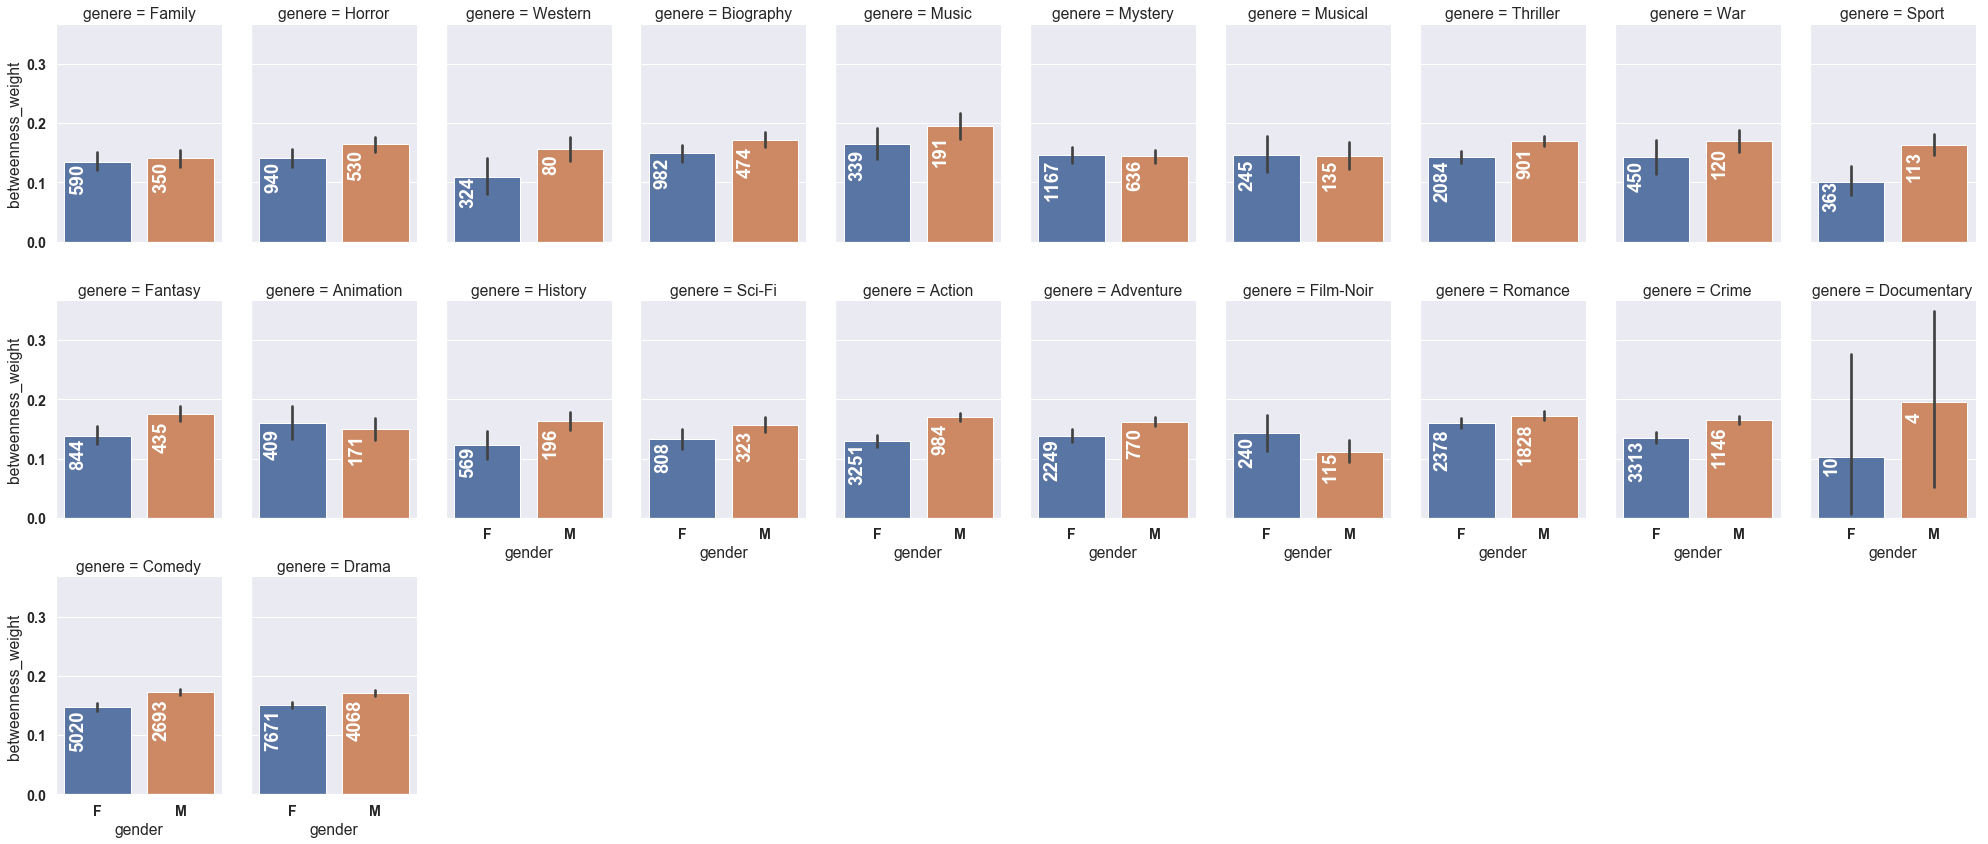

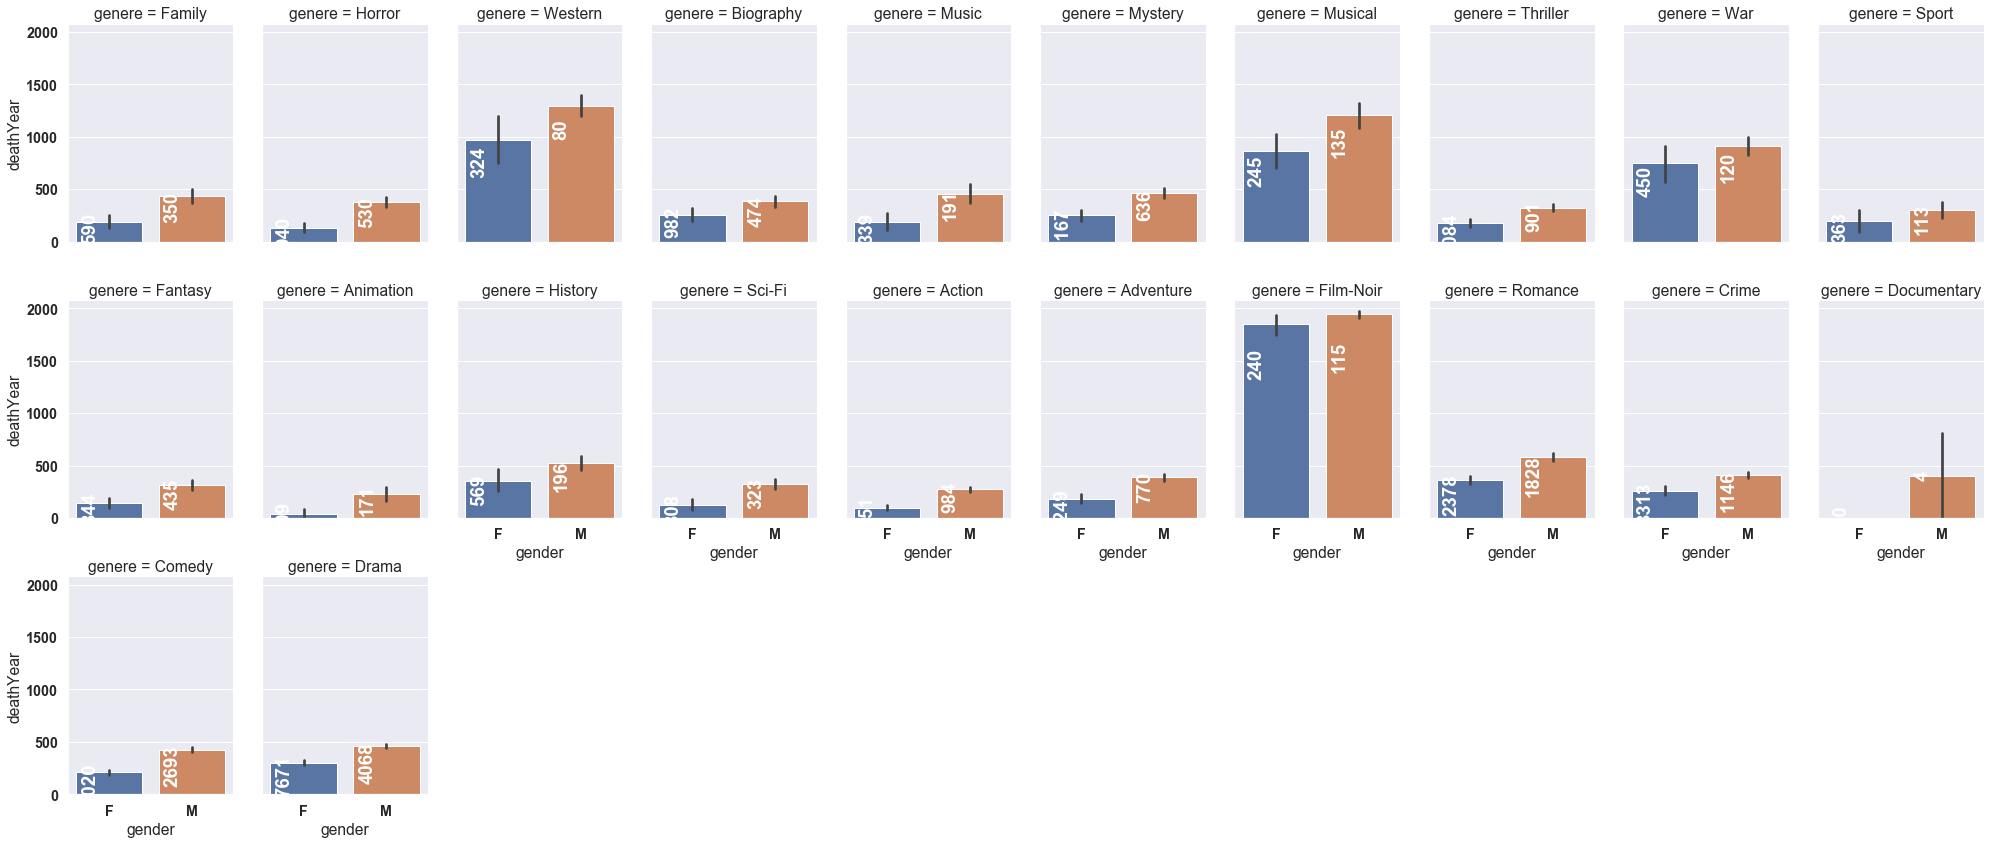

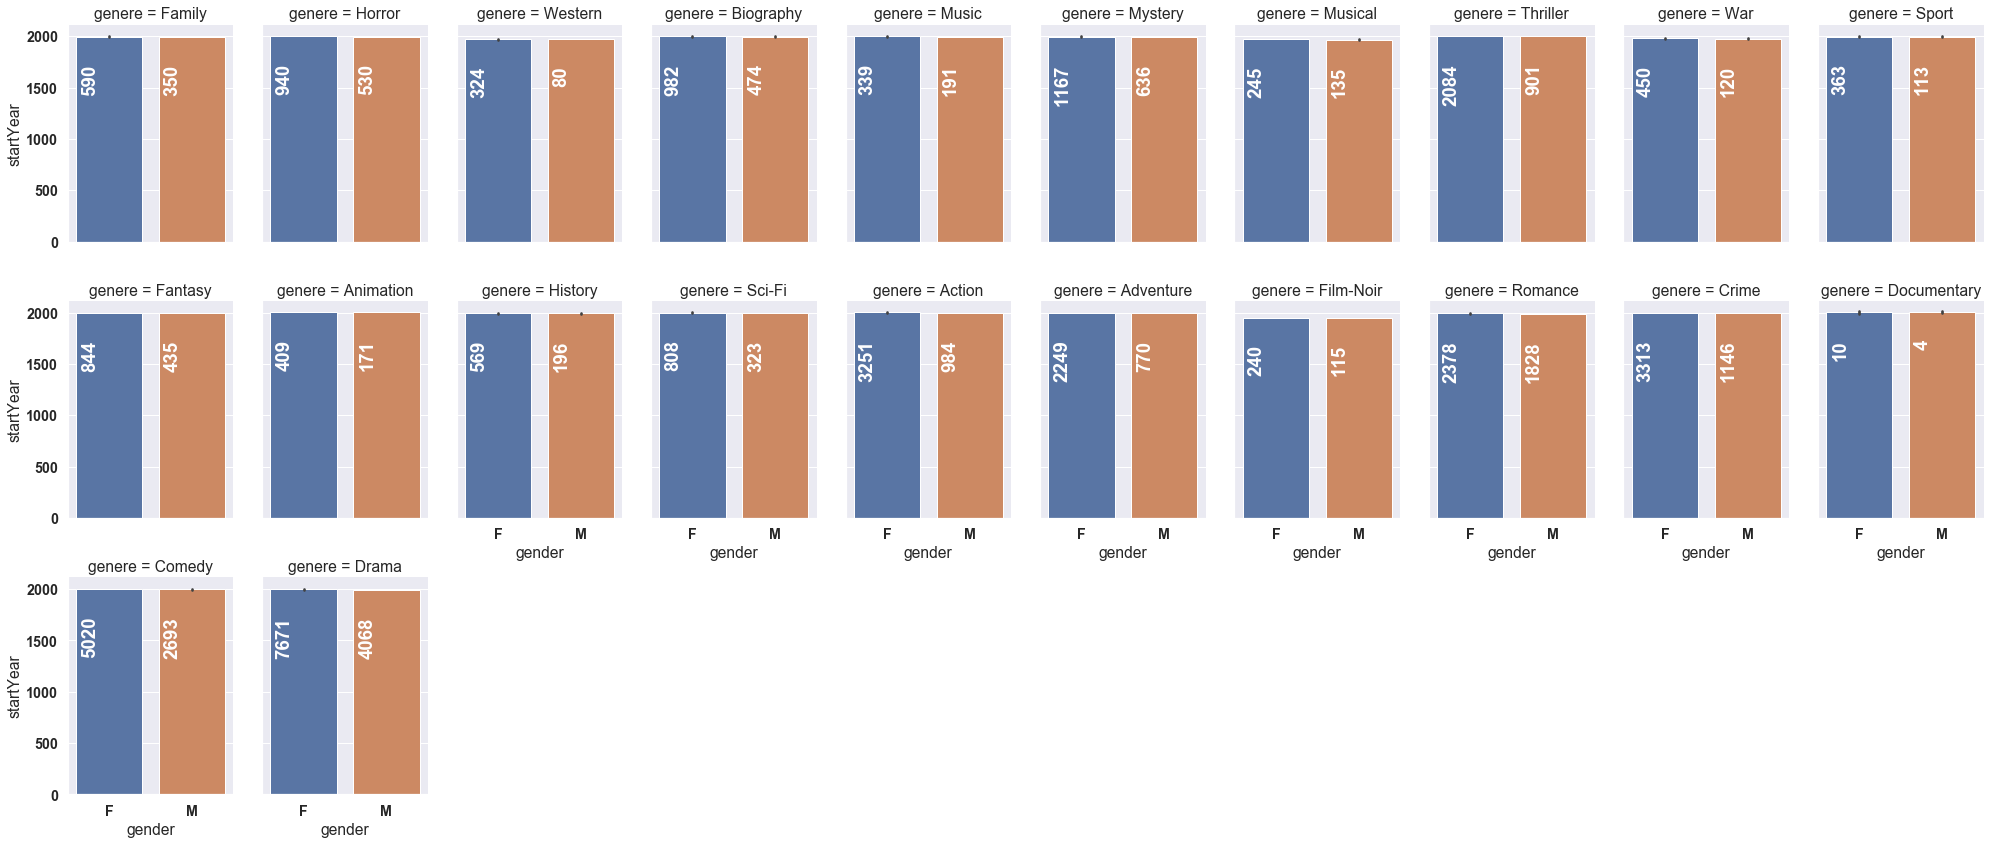

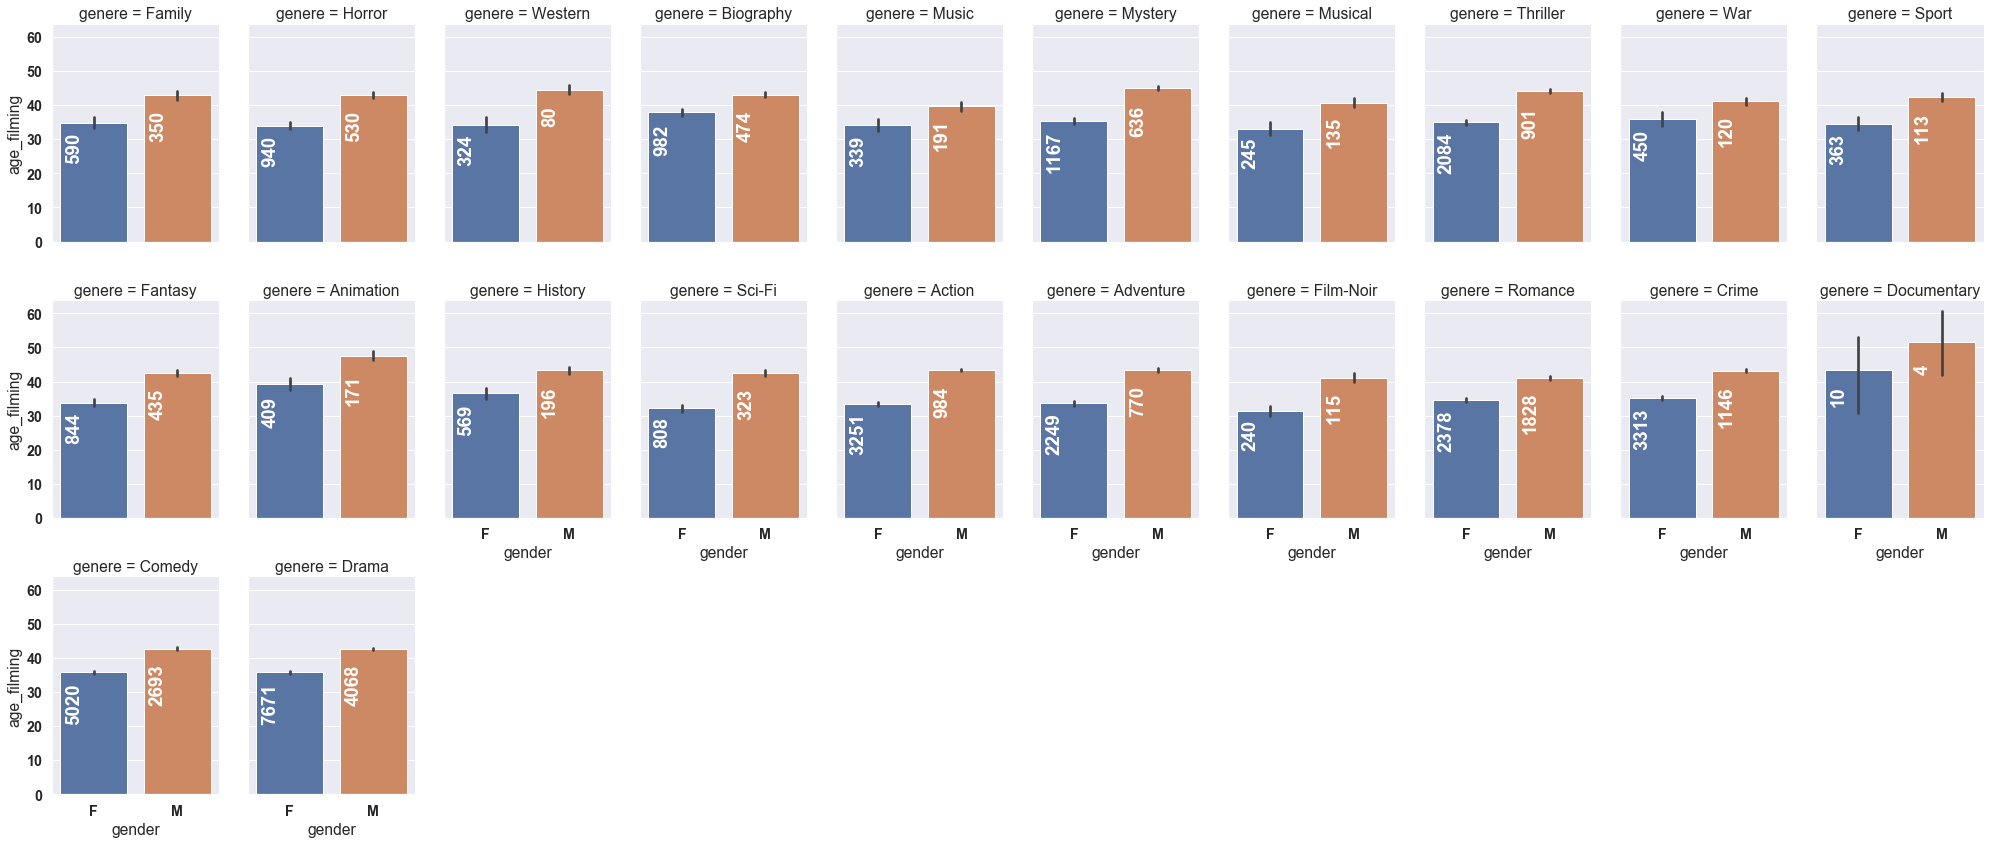

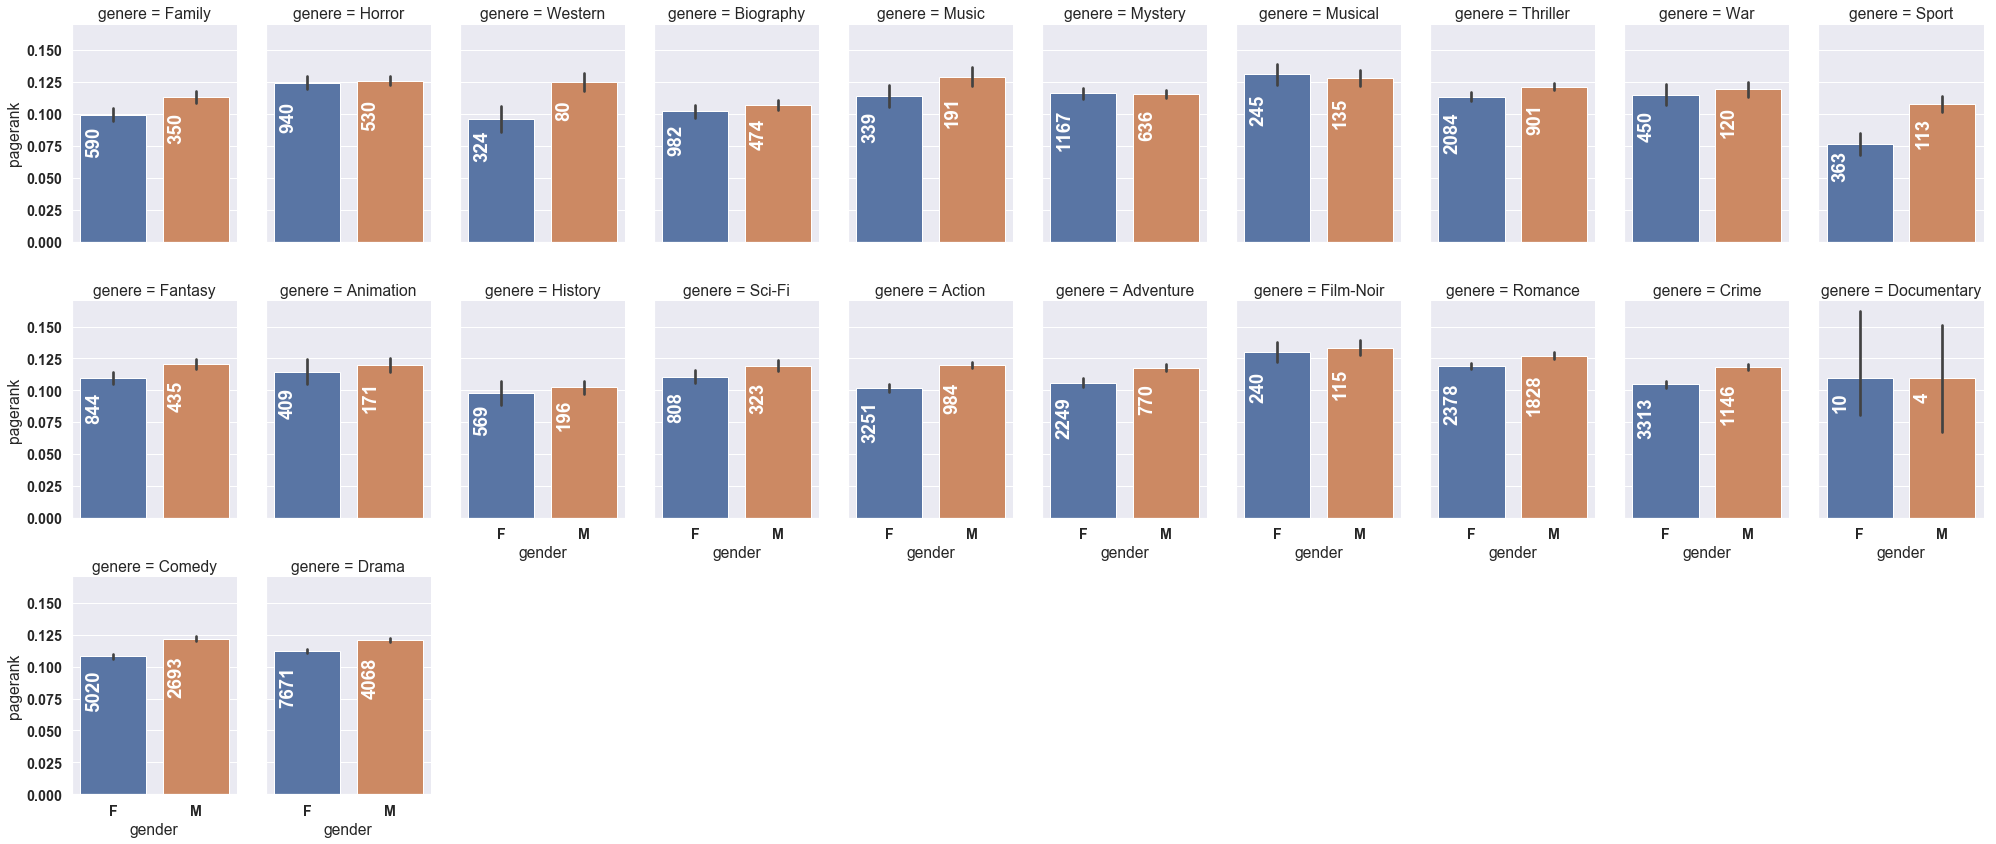

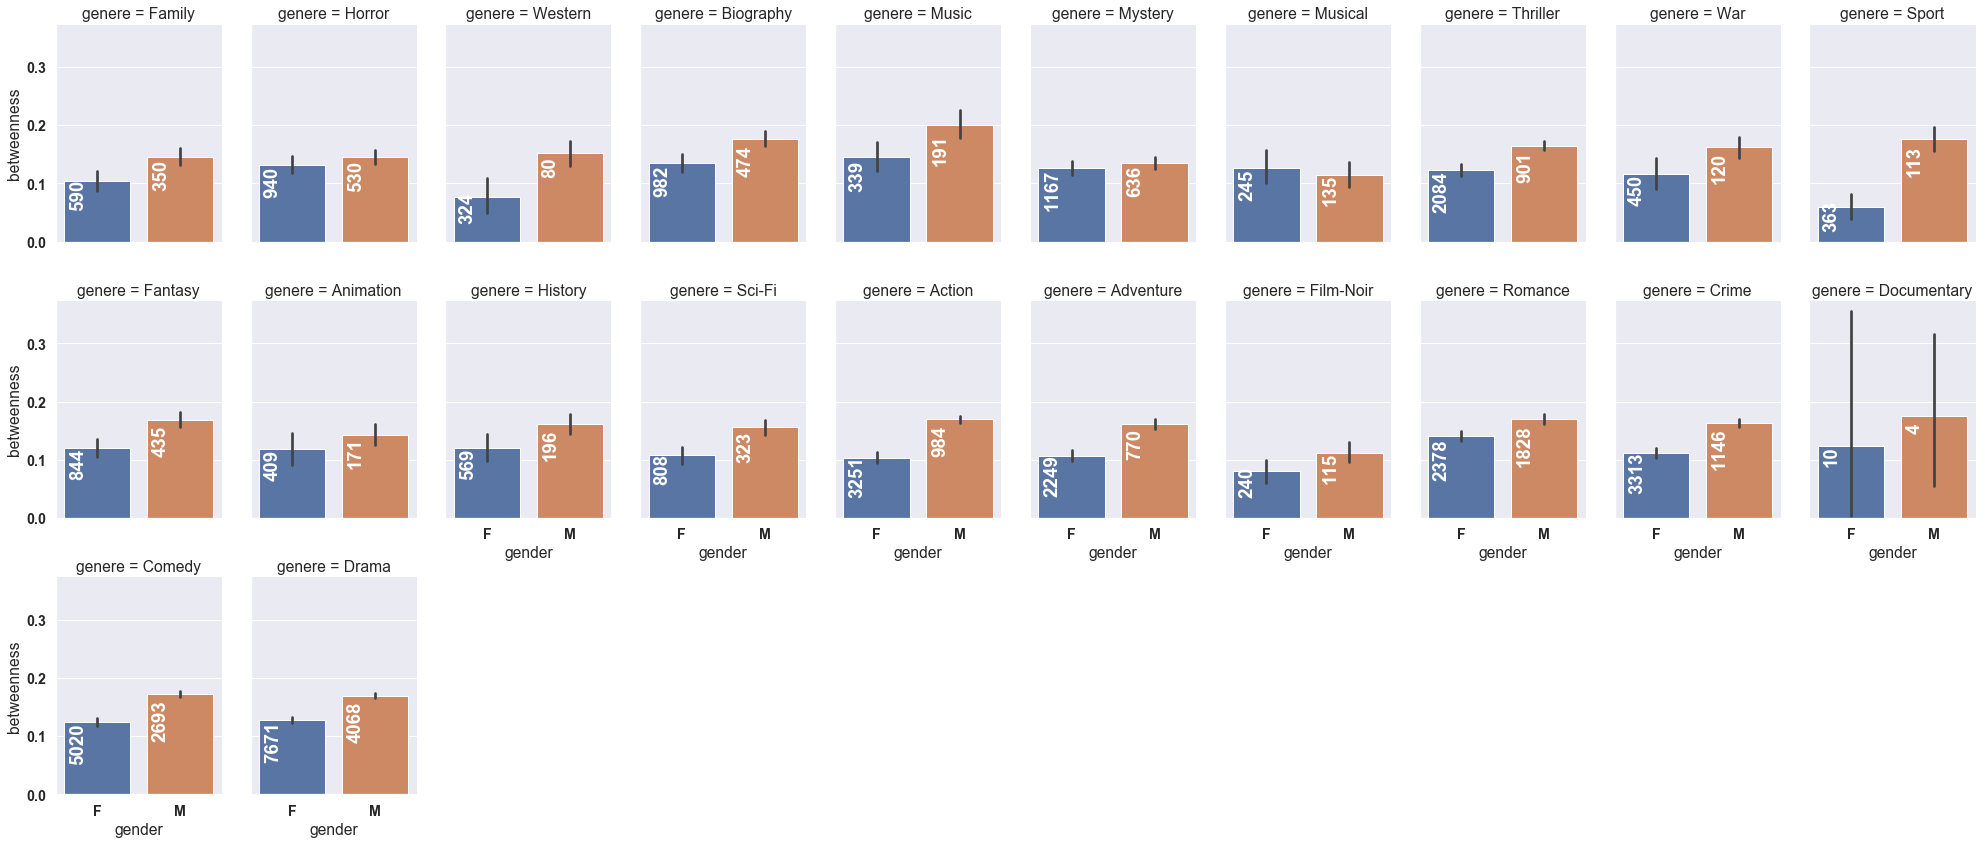

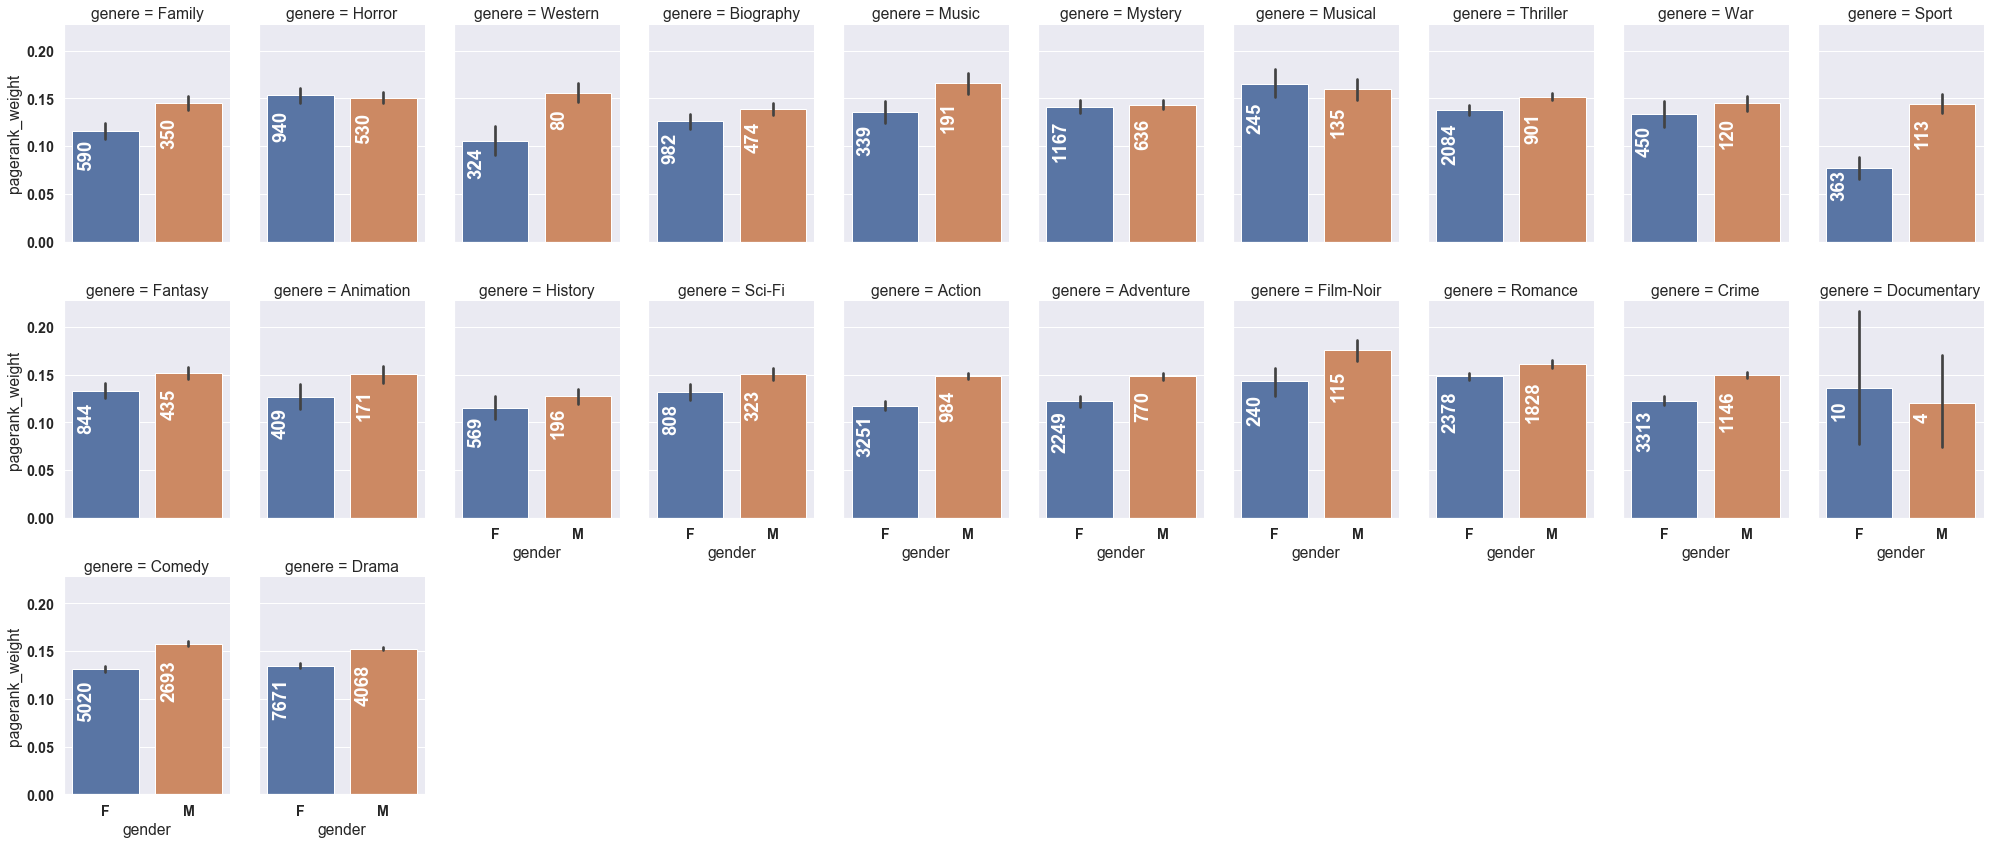

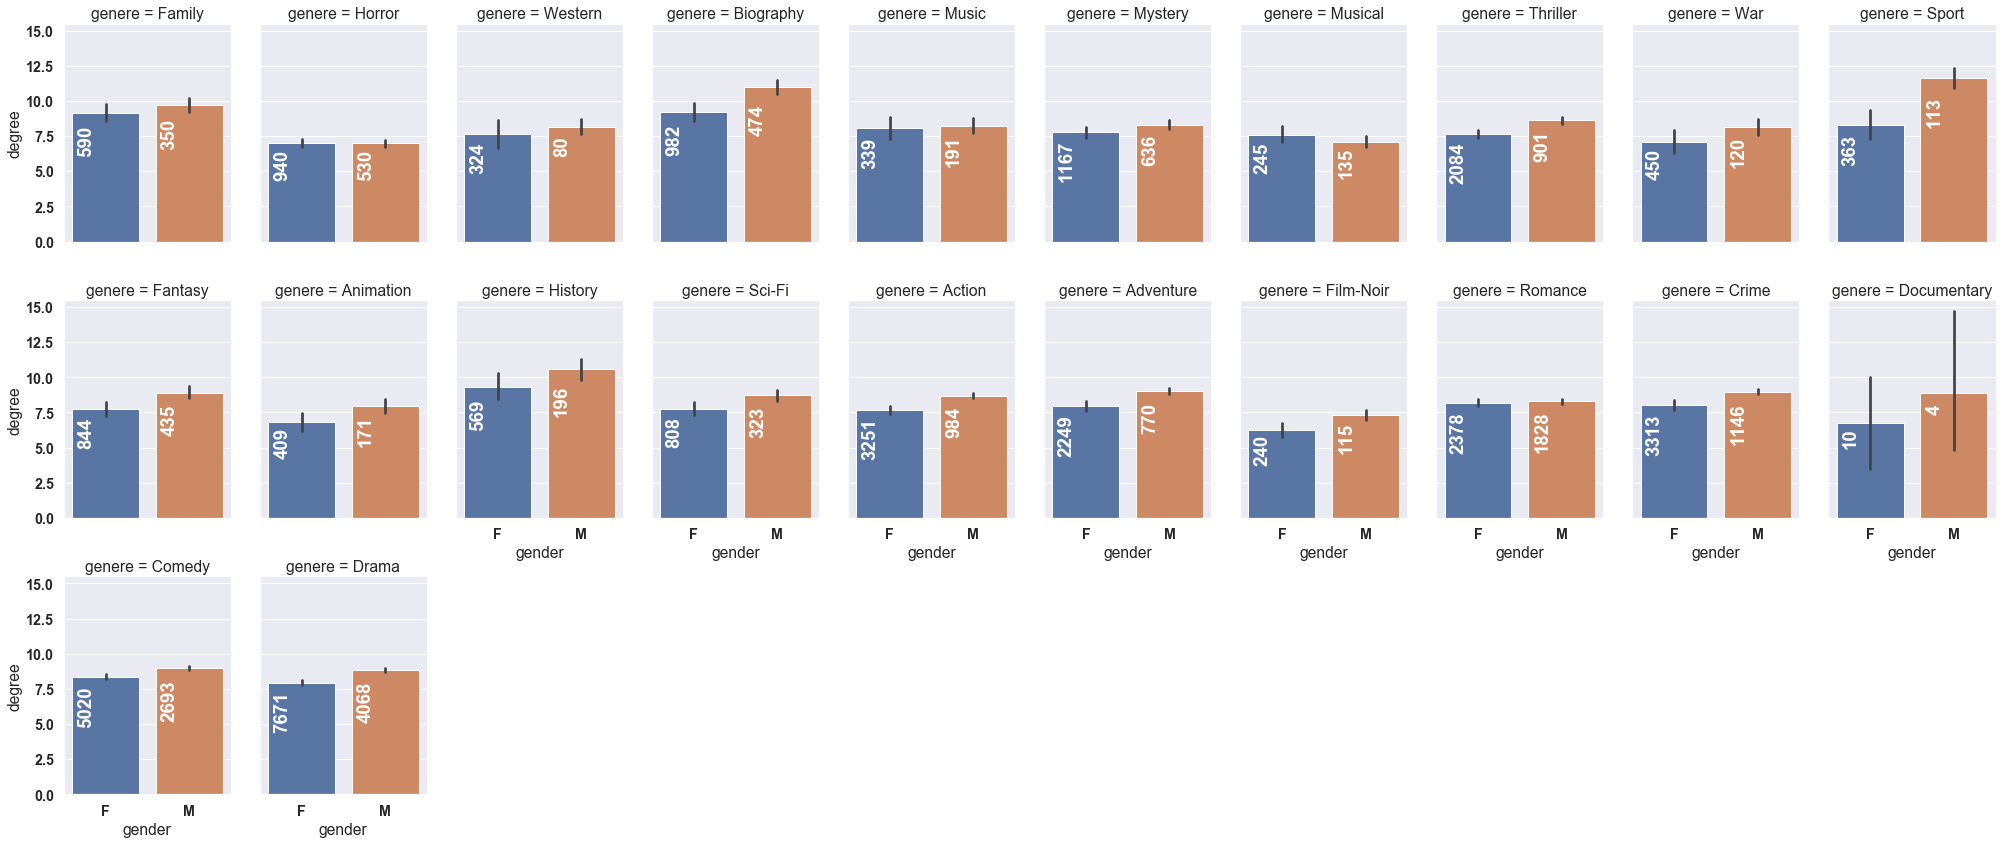

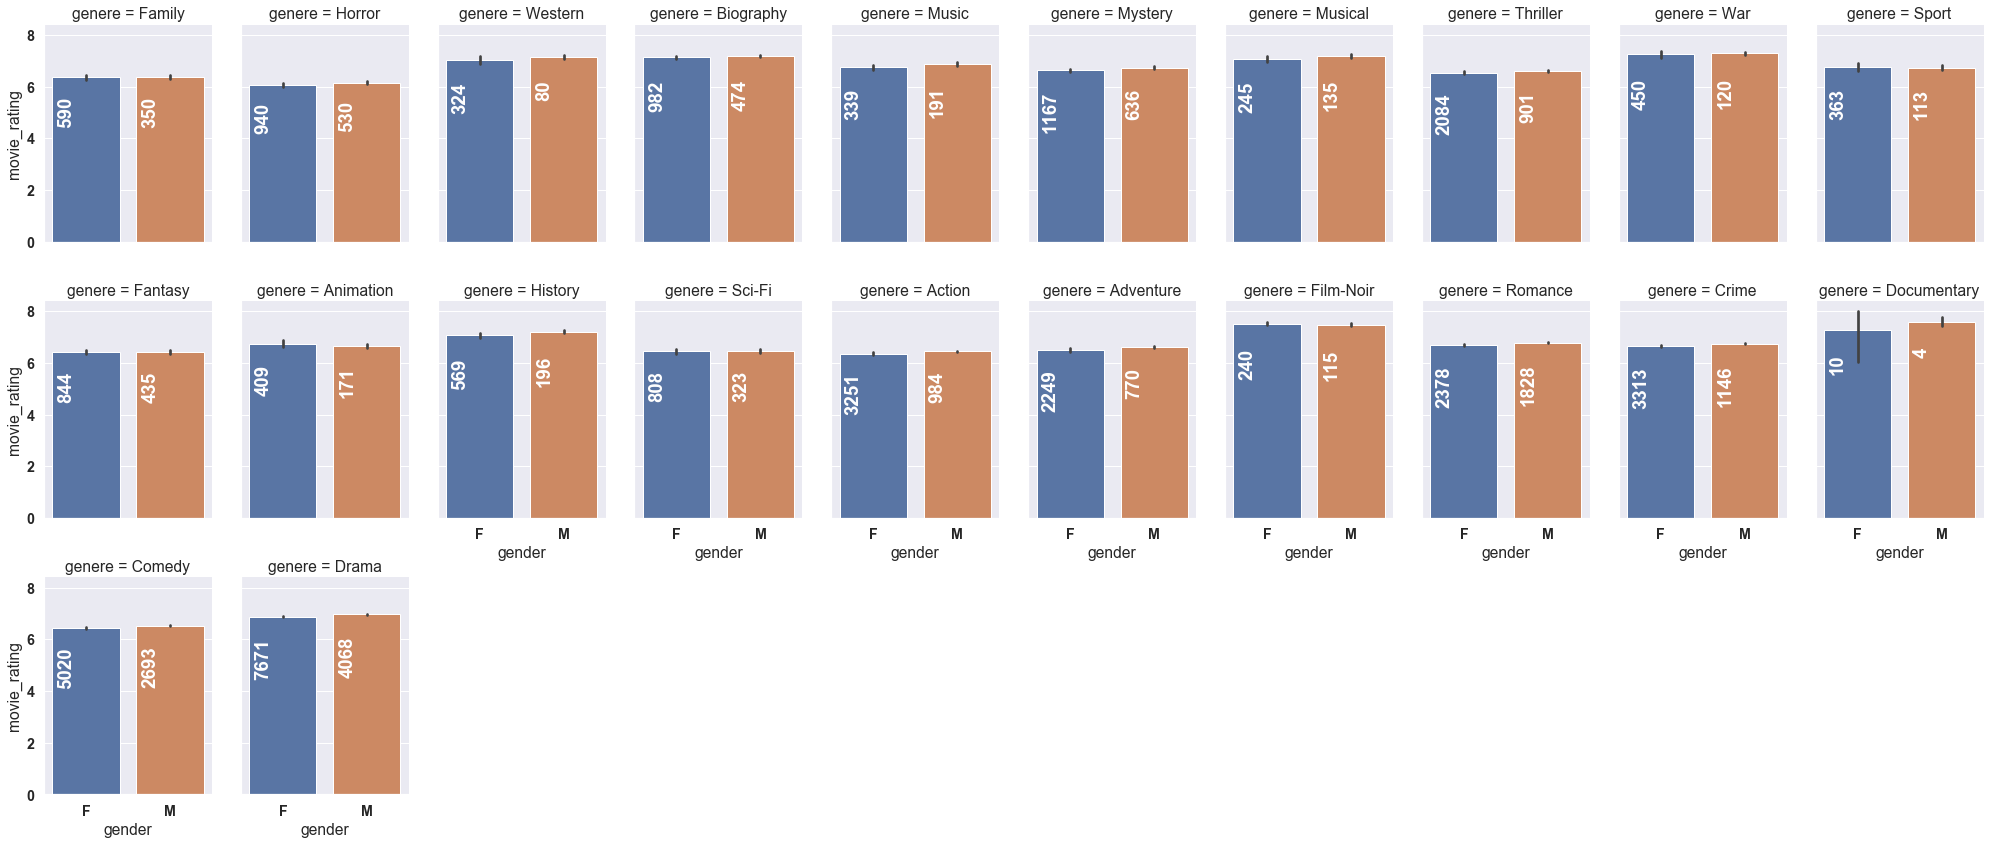

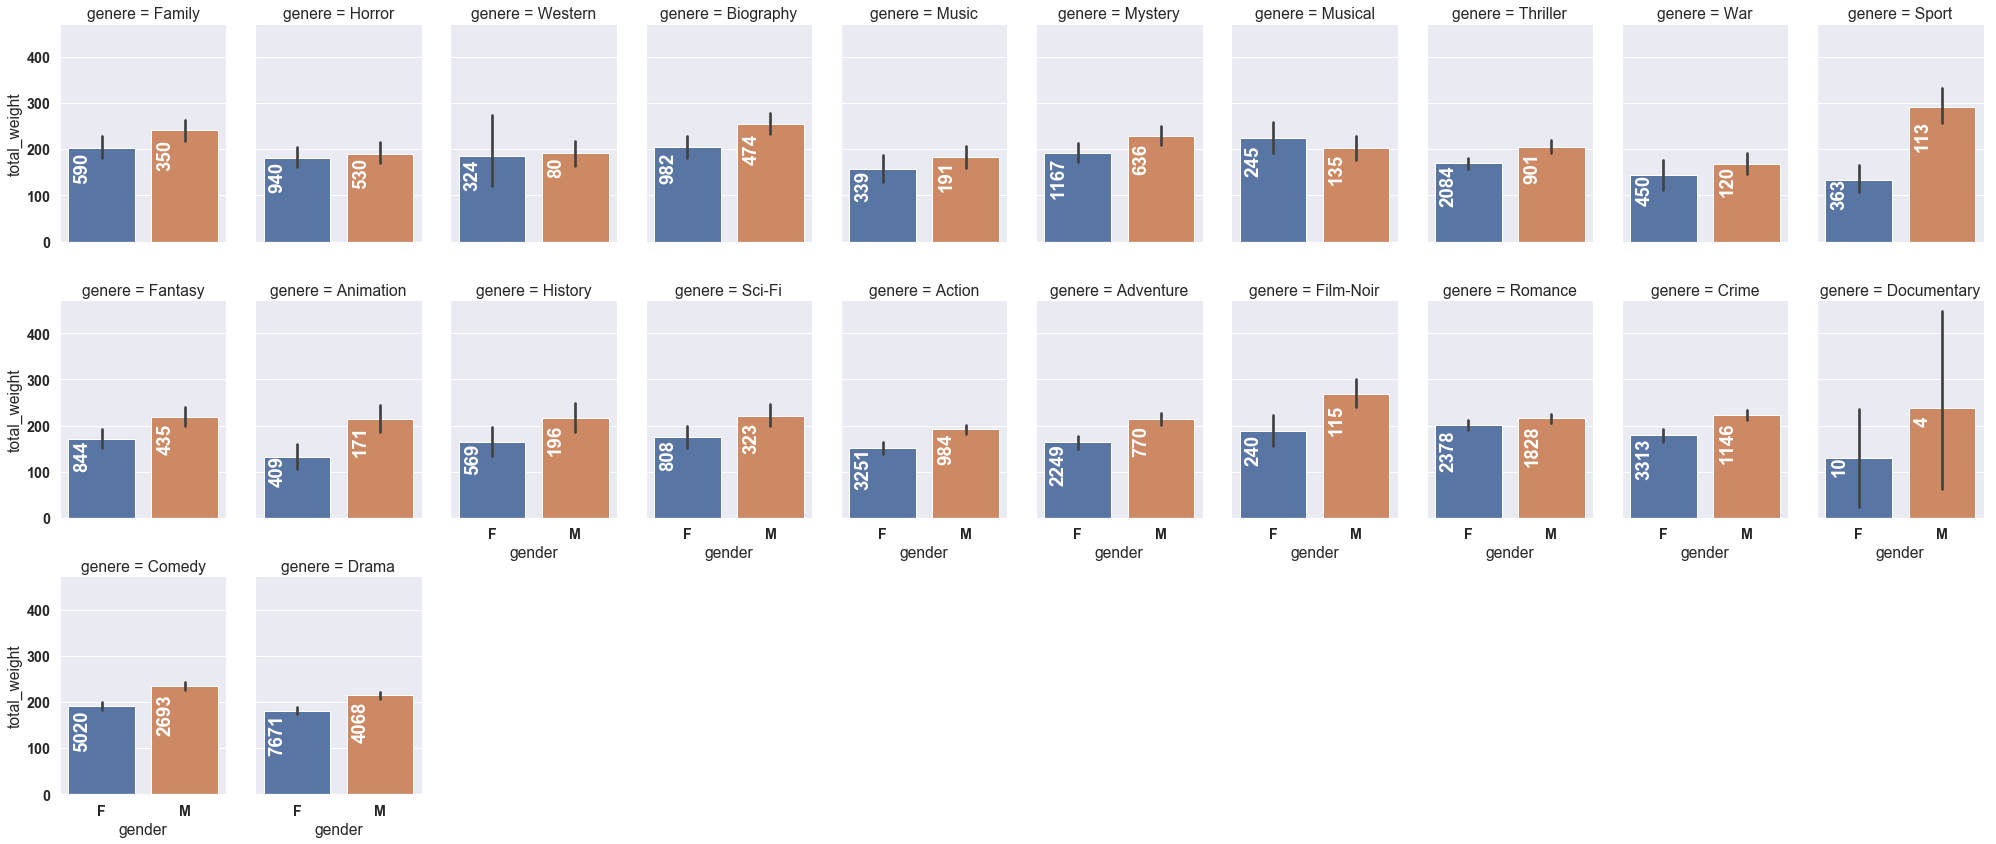

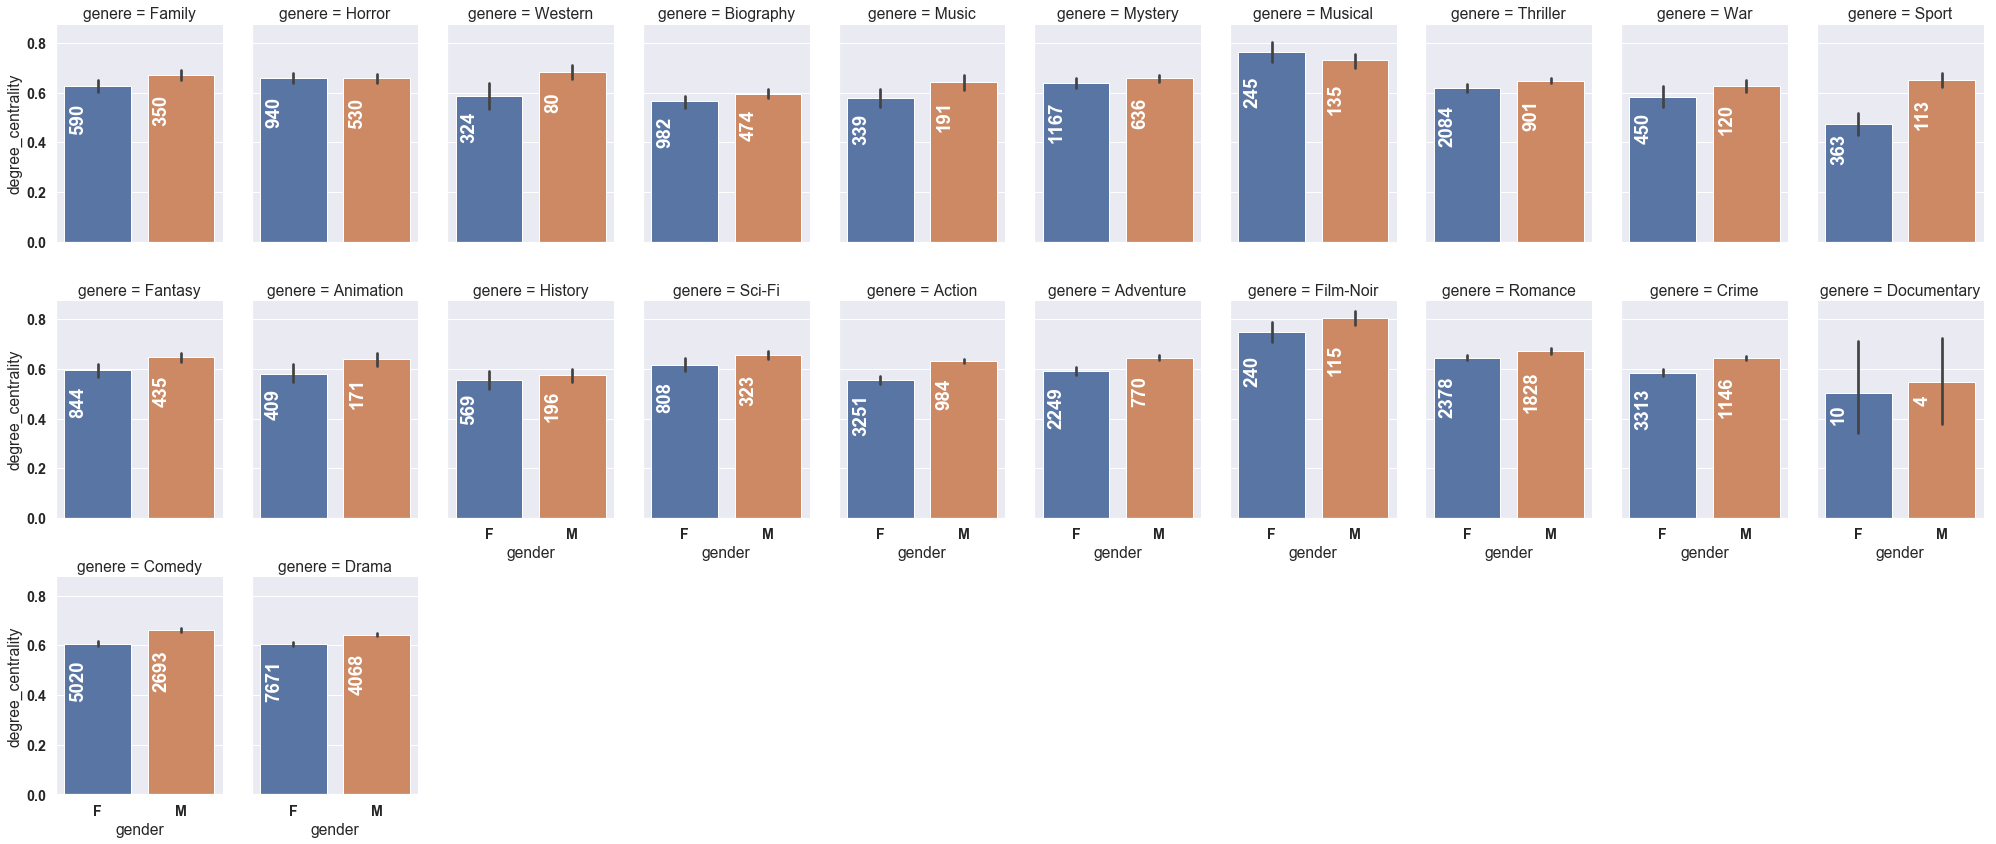

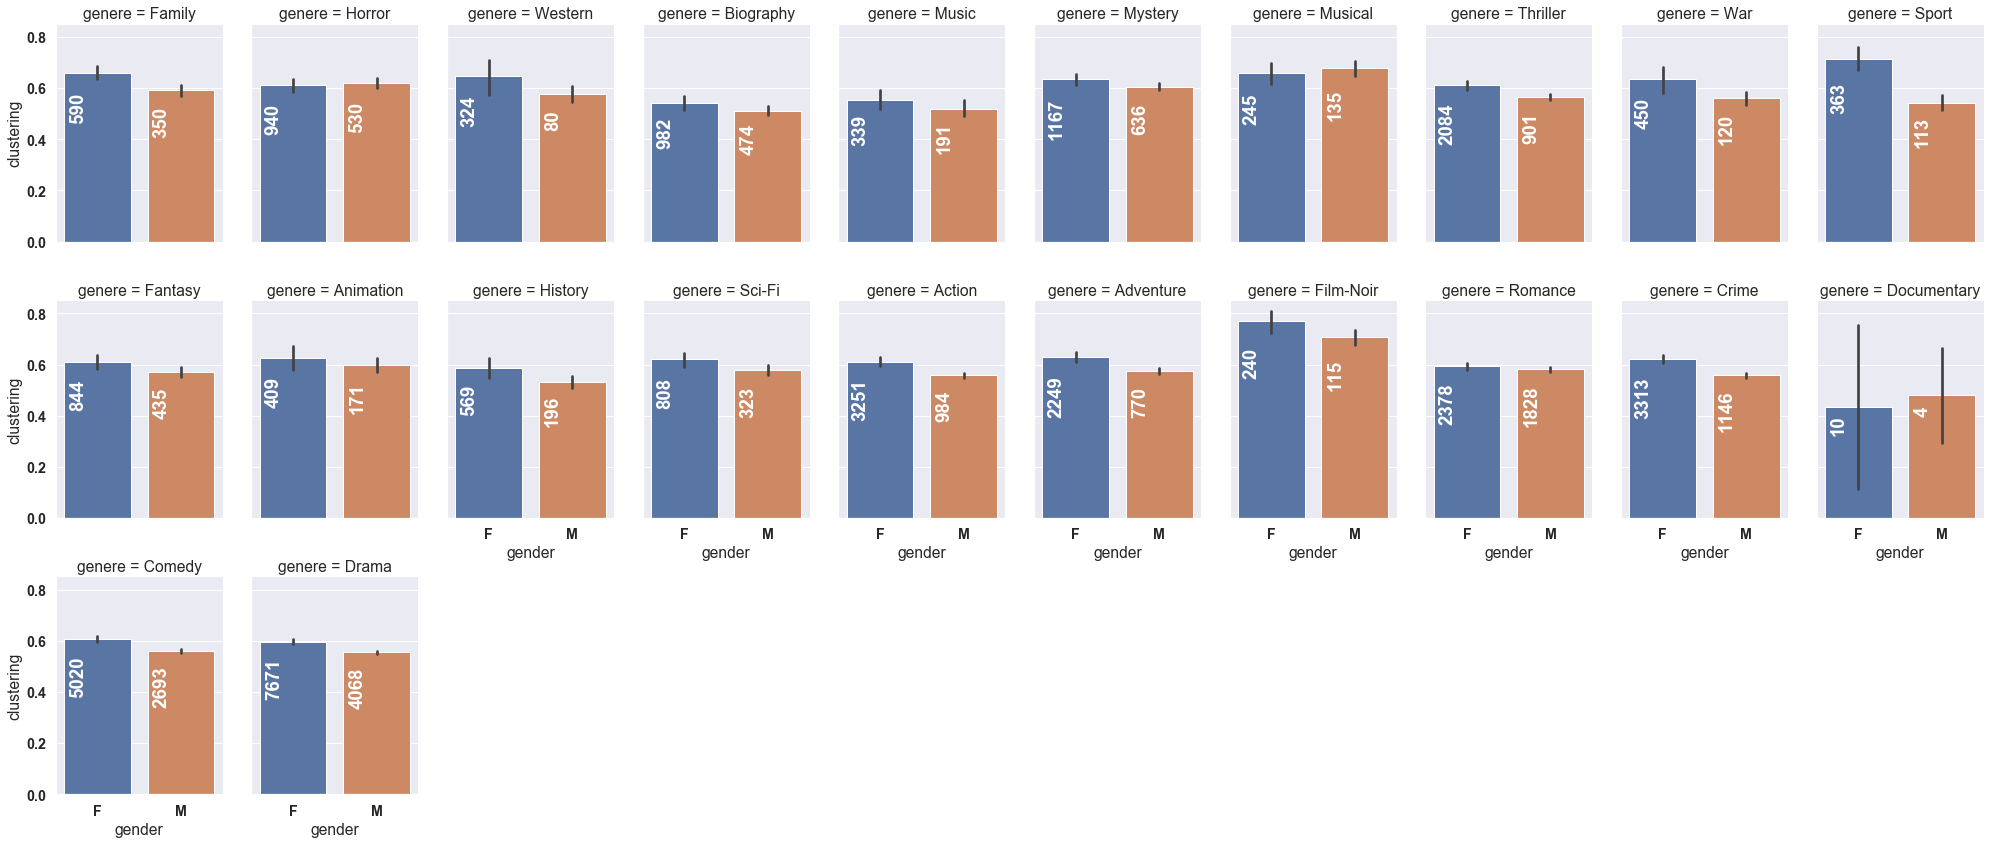

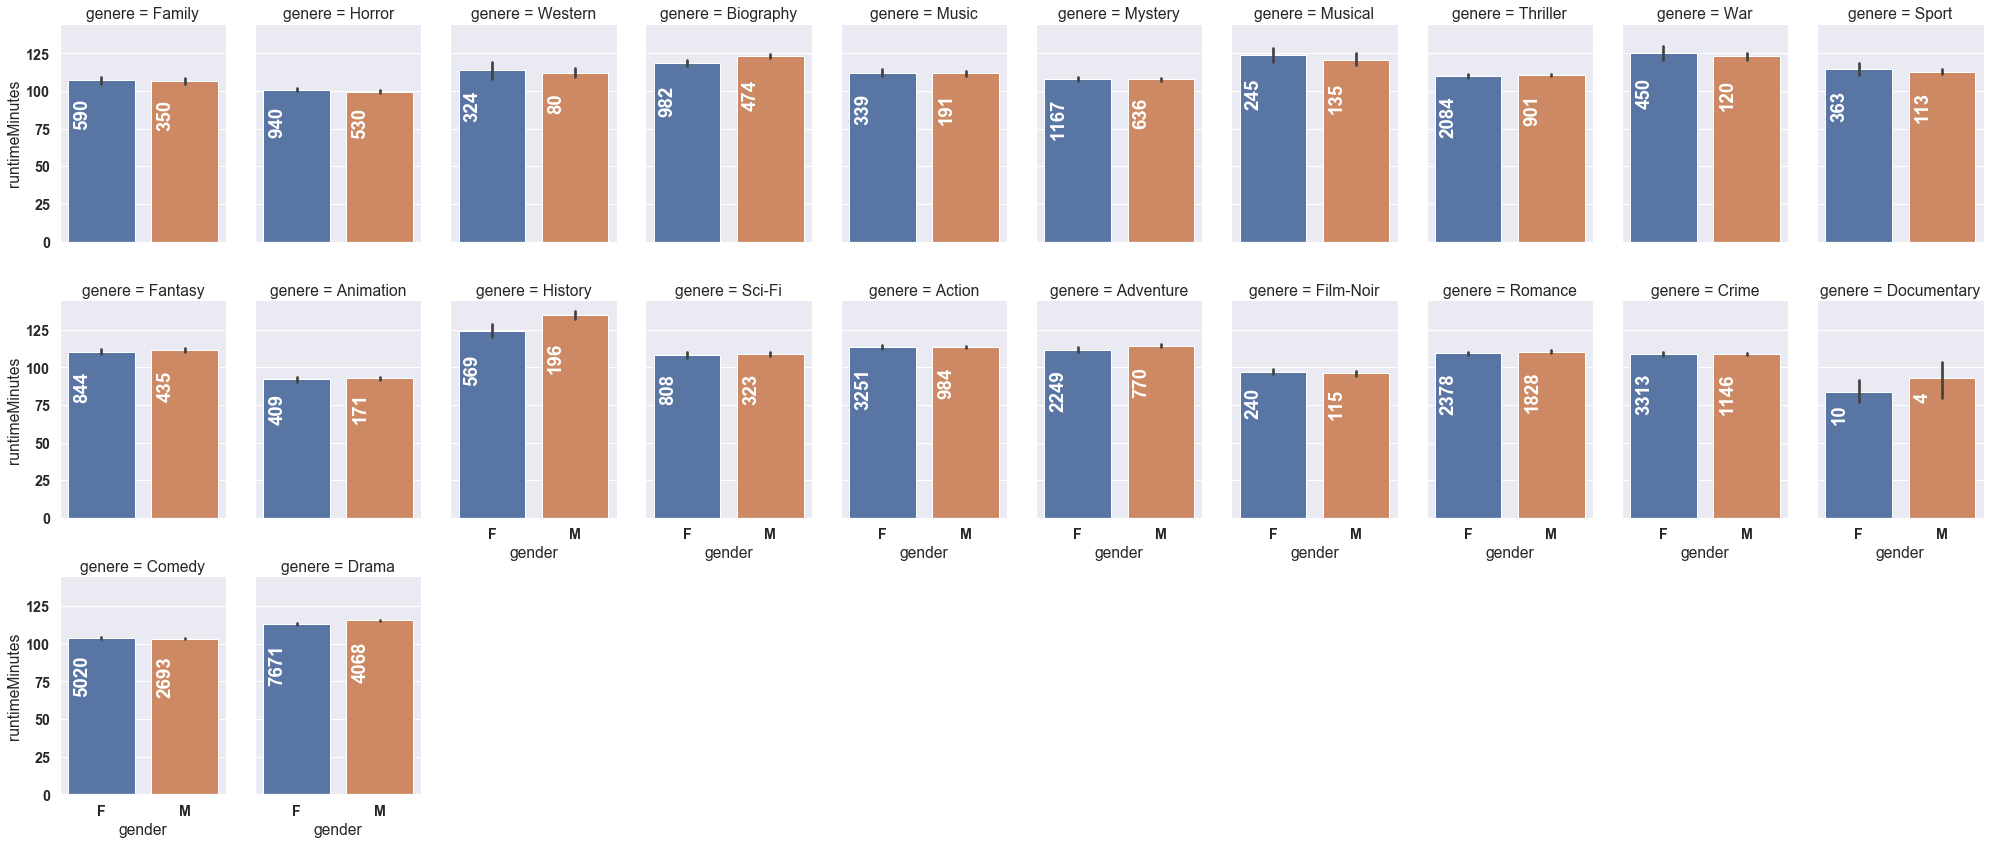

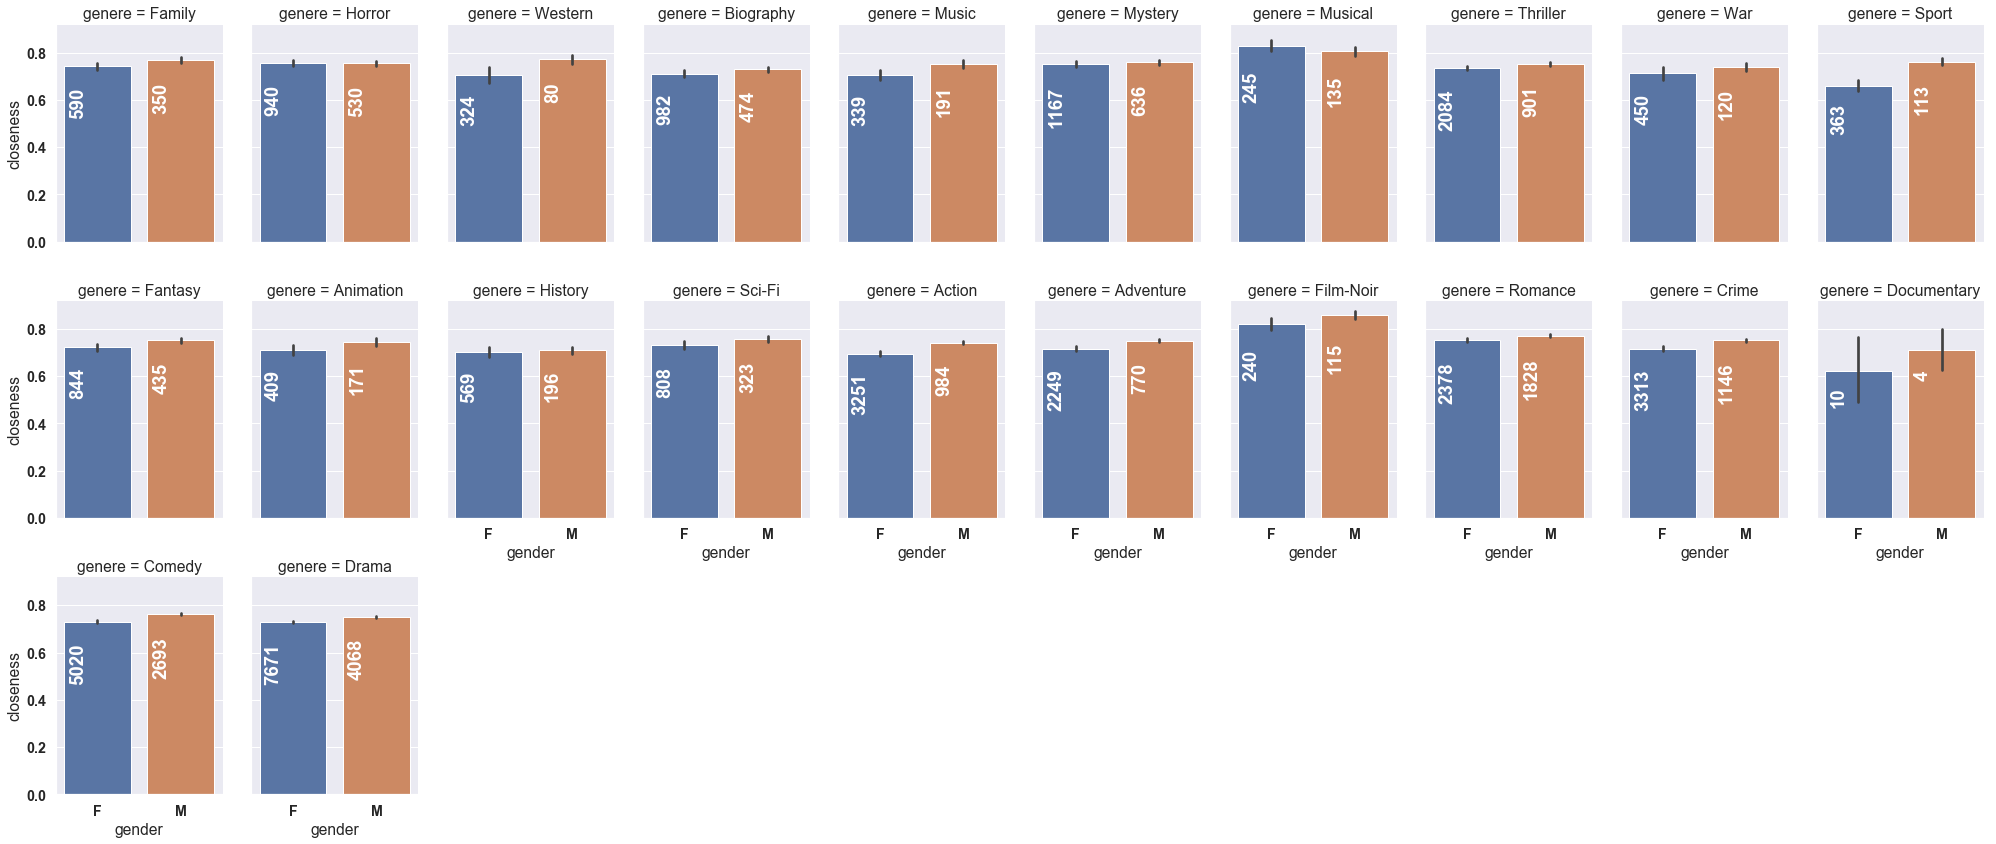

In [476]:
import seaborn as sns
bins = ["M", "F"]

for feature in id_vars:
    if feature != "gender":
        g = sns.catplot(x="gender", y=feature, col="genere",
                         data=df_chart, kind="bar", col_wrap=10,
                         height=4, aspect=.7);
        for i in np.arange(22):
        #     for j in np.arange(4):
                ax1 = g.facet_axis(0,i)
                plot_genere = ax1.title._text.split(" = ")[1]
                for i, p in enumerate(ax1.patches):
                    if str(p.get_height()) != 'nan':
                        ax1.text(p.get_x() + 0.06, p.get_height() * .8, ((df_chart["genere"]==plot_genere) & (df_chart["gender"]==bins[i])).sum(), color='white', rotation='vertical', size='large')

        g.savefig(f"features/{feature}.png")

#### Triangles

In [8]:
from turicreate import SFrame

In [271]:
from subs2graph.bechdel_classifier import get_relationship_triangles, count_triangles

In [272]:
triangles_gender_bin = get_relationship_triangles()

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 0.928636 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 590824 lines in 0.743048 secs.

In [274]:
triangles_gender_bin

X.0,X.1,X.2,movie,year,tconst,titleType,originalTitle,isAdult,endYear,runtimeMinutes
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,F,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,F,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,M,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,F,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145
F,M,F,Way Down East,1920,tt0011841,movie,Way Down East,0,None,145


In [276]:
t = count_triangles()

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 100 lines in 0.446424 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/triangles.csv

Parsing completed. Parsed 590824 lines in 0.448889 secs.

------


In [277]:
t

Males in triangle,0,1,2,3,total
Action,0.015198,0.124985,0.400085,0.459731,134224
Adventure,0.015566,0.134714,0.406634,0.443086,109981
Animation,0.022376,0.175856,0.447934,0.353834,36780
Biography,0.025059,0.145563,0.362222,0.467156,73027
Comedy,0.036693,0.198581,0.415650,0.349076,434584
Crime,0.021007,0.144931,0.401717,0.432345,141764
Documentary,0.033011,0.171134,0.390589,0.405266,149830
Drama,0.039615,0.199782,0.394673,0.365931,400912
Family,0.050702,0.212153,0.399095,0.338049,57039
Fantasy,0.034516,0.200209,0.420335,0.344940,45892


In [280]:
traingles_decade = triangles_gender_bin.groupby(["year","total_men"], operations={'count': agg.COUNT()})

In [281]:
traingles_decade["decade"] = traingles_decade["year"]//10

In [284]:
traingles_decade = pd.pivot_table(traingles_decade.to_dataframe()[["decade","total_men","count"]],index="decade", columns="total_men", values="count", fill_value=0, aggfunc=np.sum)

In [285]:
traingles_decade

total_men,0,1,2,3
decade,,,,
192,0,19,58,33
193,308,1737,4098,2835
194,622,3824,8085,6018
195,571,3164,6675,5539
196,819,3380,6364,6984
197,631,3595,9038,10352
198,1212,7719,17910,17888
199,3696,22460,53994,53775
200,7406,41002,91629,91151


In [286]:
traingles_decade["total"] = traingles_decade[0]+traingles_decade[1]+ traingles_decade[2]+ traingles_decade[3]
for i in range(4):
    traingles_decade[i] = traingles_decade[i]/traingles_decade["total"]

In [287]:
traingles_decade

total_men,0,1,2,3,total
decade,,,,,
192,0.000000,0.172727,0.527273,0.300000,110
193,0.034306,0.193473,0.456449,0.315772,8978
194,0.033533,0.206157,0.435873,0.324438,18549
195,0.035802,0.198382,0.418522,0.347295,15949
196,0.046675,0.192626,0.362683,0.398017,17547
197,0.026719,0.152227,0.382707,0.438347,23616
198,0.027097,0.172573,0.400411,0.399920,44729
199,0.027598,0.167706,0.403166,0.401531,133925
200,0.032035,0.177353,0.396340,0.394272,231188


In [289]:
triangles_gender_bin = triangles_gender_bin.unpack("genres")



In [290]:
triangles_gender_bin.save(f"../temp/gender_tri.csv", format="csv")

In [1779]:
triagles_gender_bin = SFrame.read_csv(f"../temp/gender_tri.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 100 lines in 0.300751 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/gender_tri.csv

Parsing completed. Parsed 718961 lines in 0.395449 secs.

In [291]:
triangles_gender_bin = triangles_gender_bin.pack_columns(column_name_prefix="genres")

In [292]:
triangles_df = triangles_gender_bin.to_dataframe()

In [293]:
for genre in set().union(*triangles_df.genres.values):
    triangles_df[genre] = triangles_df.apply(lambda _: int(genre in _.genres), axis=1)

In [306]:
triangles_df2 = triangles_df.drop(["1","2","3","genres"],axis=1)

In [322]:
triangles_df2 = triangles_df2.rename(columns={"total_men":"Males in triangle"})

In [308]:
triangles_df2["decade"] = triangles_df2["year"]//10

In [326]:
temp = triangles_df2.pop("year")

KeyError: 'year'

In [327]:
temp = pd.melt(triangles_df2, id_vars=['decade',"Males in triangle"], value_vars=genres) 

In [328]:
temp["decade"] = temp["decade"]*10

In [330]:
temp  = temp[temp["value"]!=0]

In [331]:
temp = temp[temp["decade"]> 1940]

In [332]:
temp = pd.pivot_table(temp,columns="Males in triangle", index=[ "variable", "decade"], aggfunc=np.sum, fill_value=0)

In [333]:
temp = temp["value"]

In [334]:
temp["total"] = temp[0]+temp[1]+ temp[2]+ temp[3]
for i in range(4):
    temp[i] = temp[i]/temp["total"]

In [335]:
tri_genre_decade = temp.reset_index()

In [336]:
tri_genre_decade= tri_genre_decade.rename({"variable":"Genre","decade":"Decade",0:3,3:0,1:2,2:1}, axis='columns')

In [337]:
tri_genre_decade = pd.melt(tri_genre_decade, id_vars=['Genre',"Decade"], value_vars=[0, 1,2,3], value_name="Percent")

In [338]:
tri_genre_decade= tri_genre_decade.rename({"Males in triangle":"Females in triangle"}, axis='columns')

In [339]:
tri_genre_decade["Percent"] = tri_genre_decade["Percent"] *100

In [340]:
tri_genre_decade

,Genre,Decade,Females in triangle,Percent
0,Action,1950,0,55.766621
1,Action,1960,0,73.209549
2,Action,1970,0,52.219570
3,Action,1980,0,52.694108
4,Action,1990,0,46.333669
5,Action,2000,0,47.041573
6,Action,2010,0,42.762415
7,Adventure,1950,0,41.210375
8,Adventure,1960,0,72.253968
9,Adventure,1970,0,63.217523


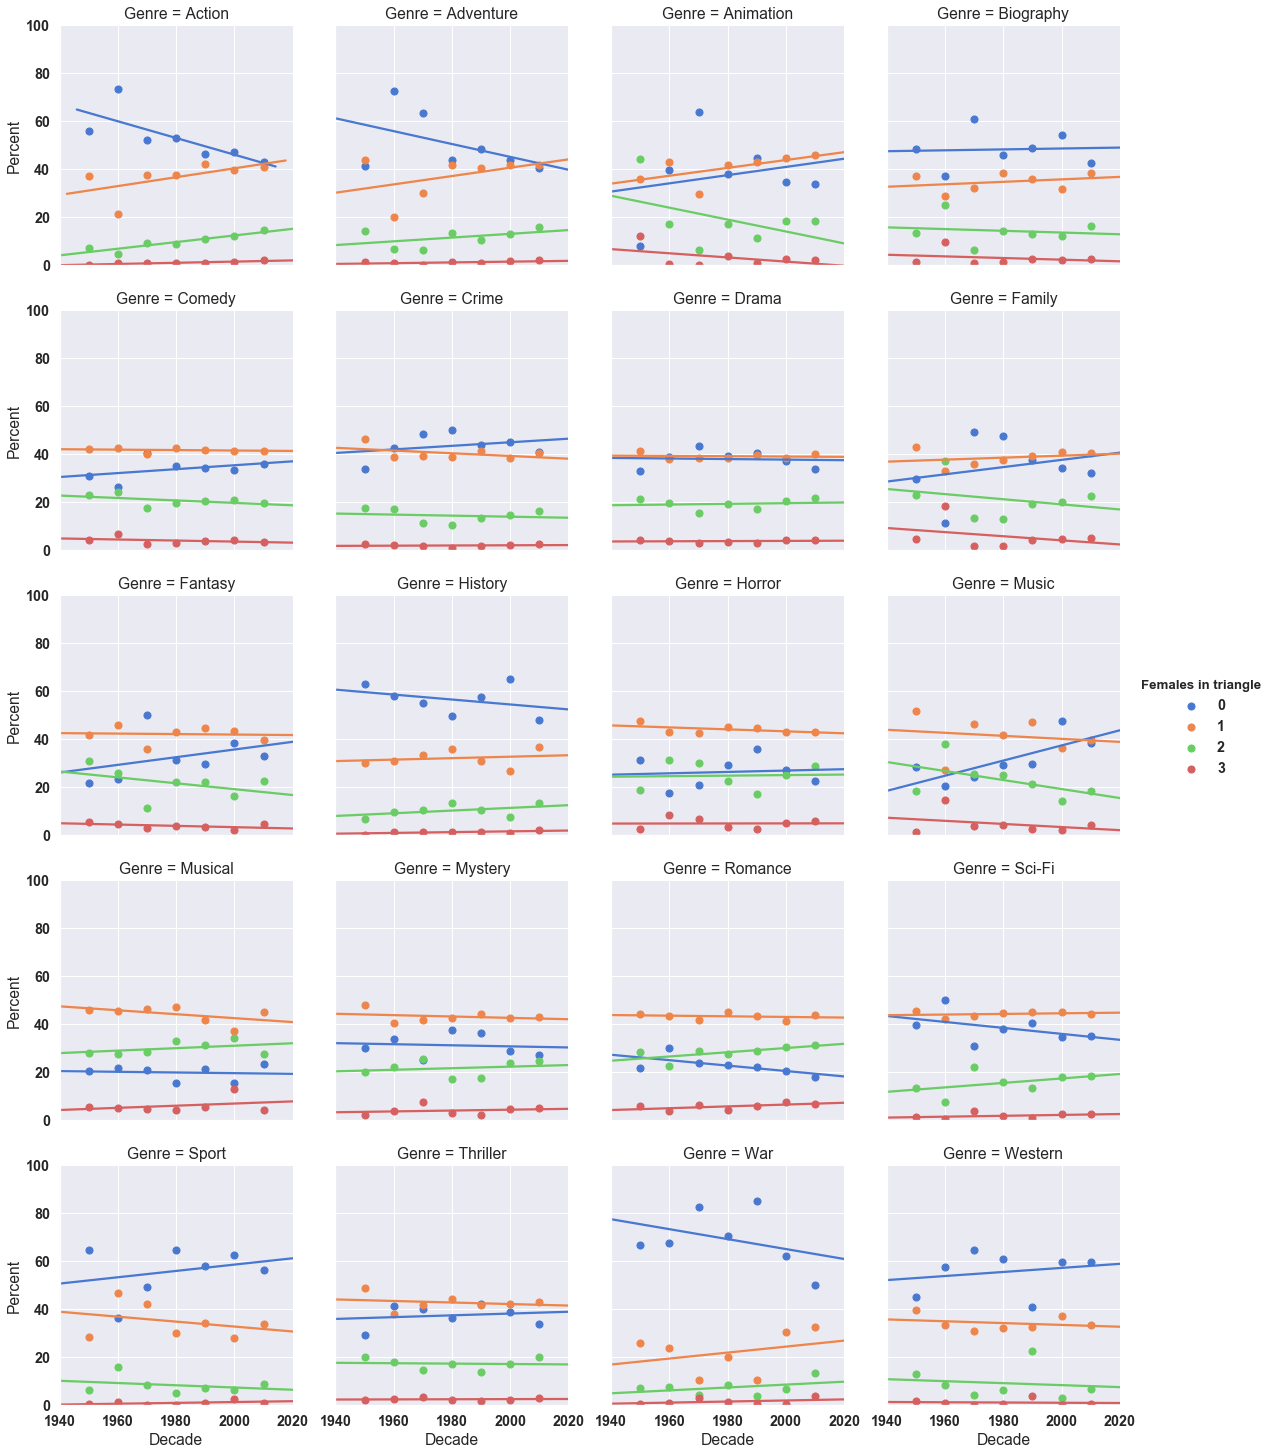

In [341]:
draw_genres = tri_genre_decade.groupby("Genre").count().query("Decade==28").index
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Load the example dataset for Anscombe's quartet

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="Decade", y="Percent", col="Genre", hue="Females in triangle", data=tri_genre_decade[tri_genre_decade["Genre"].isin(draw_genres)],
           col_wrap=4, ci=None, palette="muted", height=4,legend_out=True,
           scatter_kws={"s": 50, "alpha": 1})
g.set(xlim=(1940, 2020), ylim=(0, 100))
g.fig.tight_layout(w_pad=1)
g.fig.subplots_adjust(top=1,right=0.88)


#### Centrality

In [8]:
from itertools import islice
gender_top_movies = islice(gender_in_top_movies(), 1000)

In [9]:
gender_top_movies = list(gender_top_movies)

 11%|█▏        | 1296/11343 [01:05<12:45, 13.13it/s]  

In [10]:
import itertools
gender_top_100 = list(itertools.chain.from_iterable(gender_top_movies[:100]))
gender_top_1000 = list(itertools.chain.from_iterable(gender_top_movies))

In [11]:
print(pd.DataFrame(gender_top_100)[0].value_counts())
print(pd.DataFrame(gender_top_1000)[0].value_counts())

M    807
F    248
U      1
Name: 0, dtype: int64
M    6431
F    2390
U      11
Name: 0, dtype: int64


In [233]:
gender_centrality = pd.read_csv("../temp/gender.csv", index_col=0)

In [235]:
gender_centrality["gender"].value_counts()

M    89551
F    40149
U      370
Name: gender, dtype: int64

In [236]:
gender_centrality.groupby("movie_name")["degree_centrality"].rank(ascending=False).astype(int)

0          7
1          2
2          1
3          5
4          4
5          7
6         11
7         11
8          9
9          7
10        11
11         3
12        11
13         7
14         1
15         5
16         7
17         2
18         3
19        10
20        15
21        15
22         7
23        10
24        10
25         4
26        15
27        15
28        15
29        15
          ..
130040    10
130041    10
130042     5
130043    10
130044     5
130045    10
130046    10
130047     1
130048     2
130049     6
130050     3
130051    21
130052    15
130053     8
130054     8
130055    15
130056     4
130057    17
130058    12
130059     8
130060    21
130061    15
130062     5
130063    17
130064     8
130065    21
130066    12
130067    19
130068    21
130069    12
Name: degree_centrality, Length: 130070, dtype: int64

In [237]:
rank_pagerank = pd.Series()
rank_degree_centrality = pd.Series()
for g in gender_centrality.groupby("movie_name"):
    rank_pagerank = rank_pagerank.append(g[1]["pagerank"].rank(ascending=False)).astype(int)
    rank_degree_centrality = rank_degree_centrality.append(g[1]["degree_centrality"].rank(ascending=False).astype(int))


In [238]:
gender_centrality["rank_pagerank"] = rank_pagerank
gender_centrality["rank_degree_centrality"] = rank_degree_centrality

In [239]:
gender_centrality = gender_centrality.fillna("U")

In [240]:
rank_degree = pd.pivot_table(gender_centrality[["gender","rank_degree_centrality"]],index="gender", columns="rank_degree_centrality", aggfunc=len).T

In [241]:
rank_degree["F%"]  = rank_degree["F"] / (rank_degree["F"] + rank_degree["M"])
rank_degree["M%"]  = rank_degree["M"] / (rank_degree["F"] + rank_degree["M"])

In [242]:
rank_degree

gender,F,M,U,F%,M%
rank_degree_centrality,,,,,
1,2866.0,7566.0,15.0,0.274732,0.725268
2,3062.0,6625.0,23.0,0.316094,0.683906
3,3089.0,6637.0,17.0,0.317602,0.682398
4,3301.0,6807.0,32.0,0.326573,0.673427
5,3078.0,6635.0,23.0,0.316895,0.683105
6,3040.0,6386.0,28.0,0.322512,0.677488
7,2750.0,5848.0,28.0,0.319842,0.680158
8,2473.0,5463.0,20.0,0.311618,0.688382
9,2278.0,4951.0,22.0,0.315120,0.684880


In [243]:
rank_pagerank = pd.pivot_table(gender_centrality[["gender","rank_pagerank"]],index="gender", columns="rank_pagerank", aggfunc=len).T

In [244]:
rank_pagerank["F%"]  = rank_pagerank["F"] / (rank_pagerank["F"] + rank_pagerank["M"])
rank_pagerank["M%"]  = rank_pagerank["M"] / (rank_pagerank["F"] + rank_pagerank["M"])

In [245]:
rank_pagerank

gender,F,M,U,F%,M%
rank_pagerank,,,,,
1,2731.0,7220.0,14.0,0.274445,0.725555
2,3006.0,6509.0,24.0,0.315922,0.684078
3,3125.0,6707.0,16.0,0.317840,0.682160
4,3134.0,6745.0,32.0,0.317239,0.682761
5,3065.0,6526.0,25.0,0.319570,0.680430
6,3040.0,6298.0,27.0,0.325552,0.674448
7,2680.0,5828.0,21.0,0.314998,0.685002
8,2570.0,5468.0,18.0,0.319731,0.680269
9,2275.0,4860.0,22.0,0.318851,0.681149


In [246]:
for gender in set().union(gender_centrality.gender.values):
    gender_centrality[gender] = gender_centrality.apply(lambda _: int(gender in _.gender), axis=1)

In [247]:
gender_centrality = gender_centrality.sort_values(["movie_name", "rank_pagerank"])
pager_gcentrality = gender_centrality.groupby("movie_name").head(10)

In [248]:
pager_gcentrality.groupby("movie_name").sum().sort_values(["M","imdb_rating"], ascending=False).head(250)

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,imdb_rating,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,F,M,U
movie_name,,,,,,,,,,,,,,,,
The Shawshank Redemption - roles,0.770760,1.289474,6.748938,6.225606,91,4.789474,93.0,0.748761,0.837844,1804,19940,55,54,0,10,0
The Lord of the Rings: The Fellowship of the Ring - roles,0.648900,0.805797,7.622526,6.009341,160,6.666667,88.0,0.632263,0.803120,4358,20010,55,53,0,10,0
Avengers: Infinity War - roles,0.787770,0.900041,6.886712,5.290329,153,5.275862,86.0,0.582071,0.709191,2967,20180,55,54,0,10,0
City of God - roles,1.120879,1.510989,5.631050,6.118398,43,3.071429,86.0,0.865236,0.907828,438,20020,55,56,0,10,0
Tom Petty and the Heartbreakers: Runnin' Down a Dream - roles,0.493683,0.487314,8.175863,6.042015,259,7.617647,86.0,0.457901,0.657946,9205,20070,54,53,0,10,0
Apocalypse Now - roles,0.955556,1.133333,5.857241,2.711111,23,2.300000,85.0,0.952794,0.977158,259,19790,57,57,0,10,0
The Departed - roles,0.746215,0.785511,7.178174,5.420265,193,5.848485,85.0,0.564852,0.713698,3538,20060,55,54,0,10,0
The Human Condition II: Road to Eternity - roles,0.934783,1.349034,5.995254,6.986646,66,2.750000,85.0,0.730480,0.810276,813,19590,53,55,0,10,0
Lion of the Desert - roles,1.054545,1.236364,5.612657,7.088889,30,2.727273,84.0,0.924909,0.943585,165,19800,54,56,0,10,0


In [249]:
t = pager_gcentrality.groupby("movie_name").sum()

In [250]:
t = t[t["M"]+t["F"]==10]

In [252]:
gender_centrality[gender_centrality["movie_name"]=="Toy Story - roles"]

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,gender,imdb_rating,movie_name,name,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,F,M,U
6089,0.322674,0.307190,0.857143,0.523810,15,0.833333,M,8.3,Toy Story - roles,Tim Allen,0.104261,0.175972,658,1995,1,1,0,1,0
6090,0.123327,0.217865,0.818182,0.615385,14,0.777778,M,8.3,Toy Story - roles,Tom Hanks,0.088520,0.170647,671,1995,2,2,0,1,0
6099,0.099907,0.006536,0.782609,0.666667,13,0.722222,M,8.3,Toy Story - roles,John Morris,0.082519,0.135602,532,1995,3,3,0,1,0
6092,0.120915,0.111111,0.750000,0.712121,12,0.666667,M,8.3,Toy Story - roles,Erik von Detten,0.078536,0.083825,290,1995,4,4,0,1,0
6093,0.015484,0.104575,0.750000,0.818182,12,0.666667,F,8.3,Toy Story - roles,Sherry Lynn,0.072868,0.051656,191,1995,5,4,1,0,0
6096,0.005135,0.294118,0.720000,0.909091,11,0.611111,M,8.3,Toy Story - roles,Mazlum Kiper,0.066881,0.033016,111,1995,7,7,0,1,0
6097,0.005135,0.078431,0.720000,0.909091,11,0.611111,M,8.3,Toy Story - roles,Wallace Shawn,0.066881,0.048050,176,1995,7,7,0,1,0
6100,0.005135,0.039216,0.720000,0.909091,11,0.611111,M,8.3,Toy Story - roles,Don Rickles,0.066881,0.058752,224,1995,7,7,0,1,0
6094,0.006536,0.174292,0.692308,0.888889,10,0.555556,M,8.3,Toy Story - roles,Toygun Ates,0.062078,0.037045,126,1995,9,9,0,1,0
6091,0.001634,0.006536,0.666667,0.972222,9,0.500000,F,8.3,Toy Story - roles,Füsun Kokucu,0.056172,0.040992,147,1995,10,10,1,0,0


In [253]:
t.sort_values("M", ascending=False)

,betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality,imdb_rating,pagerank,pr_weight,total_weight,year,rank_pagerank,rank_degree_centrality,F,M,U
movie_name,,,,,,,,,,,,,,,,
'71 - roles,1.628205,1.724359,4.779832,5.619048,42,3.230769,72.0,0.874324,0.888889,207,20140,53,53,0,10,0
The Outsider - roles,0.847619,1.447619,6.646022,7.350649,72,4.800000,63.0,0.844188,0.884086,880,20180,54,55,0,10,0
Outlaw - roles,1.090909,1.245455,5.787945,5.616667,42,3.818182,58.0,0.937833,0.947485,236,20070,54,55,0,10,0
Doing Time - roles,1.032680,1.198802,6.018203,6.186258,72,4.000000,72.0,0.765018,0.820835,473,19790,55,55,0,10,0
Avicii: True Stories - roles,1.169591,1.418129,5.685869,6.142857,59,3.105263,77.0,0.773533,0.853477,551,20170,56,55,0,10,0
Avengers: Infinity War - roles,0.787770,0.900041,6.886712,5.290329,153,5.275862,86.0,0.582071,0.709191,2967,20180,55,54,0,10,0
The Muppet Movie - roles,0.781818,1.872727,6.612235,7.042063,58,5.272727,76.0,0.944930,0.970329,1243,19790,55,53,0,10,0
The Name of the Rose - roles,0.722059,1.071078,7.066591,6.535936,99,5.823529,78.0,0.737778,0.844105,1795,19860,55,56,0,10,0
The Natural - roles,0.778947,0.961404,6.771758,6.019583,94,4.700000,75.0,0.716064,0.851787,1757,19840,55,53,0,10,0


In [254]:
t["M"].value_counts()

7     1409
8     1335
6     1207
9      864
5      754
4      373
10     325
3      128
2       46
1        7
0        4
Name: M, dtype: int64

In [255]:
t["F"].value_counts()

3     1409
2     1335
4     1207
1      864
5      754
6      373
0      325
7      128
8       46
9        7
10       4
Name: F, dtype: int64

In [256]:
t["M"].value_counts() + t["F"].value_counts()

0      329
1      871
2     1381
3     1537
4     1580
5     1508
6     1580
7     1537
8     1381
9      871
10     329
dtype: int64

In [257]:
hist_df = pd.DataFrame()
hist_df["F"]= t["F"].value_counts() 
hist_df["M"]=t["M"].value_counts()

In [258]:
hist_df = hist_df.sort_index()

[1.21580547112462, 0.8036739380022963, 3.33091962346126, 8.327911515940144, 23.60759493670886, 50.0, 76.39240506329114, 91.67208848405986, 96.66908037653874, 99.19632606199771, 98.78419452887537]
[98.78419452887537, 99.19632606199771, 96.66908037653874, 91.67208848405986, 76.39240506329114, 50.0, 23.60759493670886, 8.327911515940144, 3.33091962346126, 0.8036739380022963, 1.21580547112462]


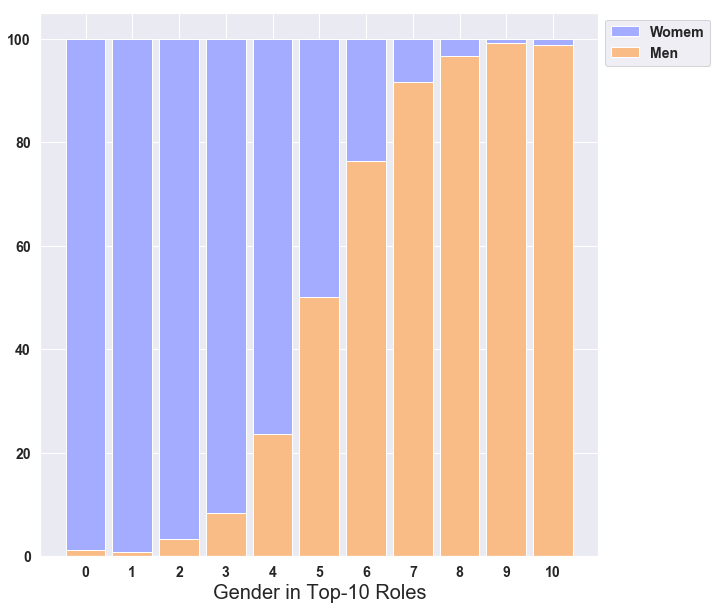

In [259]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
plt.figure(figsize=(10,10)) 

# Data
r = [0,1,2,3,4,5,6,7,8,9,10]
raw_data = {'male': hist_df["M"],'female': hist_df["F"]}
df = pd.DataFrame(raw_data)

# From raw value to percentage
totals = [i+j for i,j in zip(df['male'], df['female'])]
mBars = [i / j * 100 for i,j in zip(df['male'], totals)]
fBars = [i / j * 100 for i,j in zip(df['female'], totals)]
print(mBars)
print(fBars)

# plot
barWidth = 0.85
names = [0,1,2,3,4,5,6,7,8,9,10]
# Create green Bars
# Create orange Bars
plt.bar(r, fBars, bottom=mBars, color='#a3acff', edgecolor='white', width=barWidth, label="Womem")


plt.bar(r, mBars, bottom=0, color='#f9bc86', edgecolor='white', width=barWidth, label="Men")

# Create blue Bars

# Custom x axis
plt.xticks(r, names, size=14)
plt.yticks(size=14)

plt.xlabel("Gender in Top-10 Roles", size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':14})

# Show graphic
plt.show()


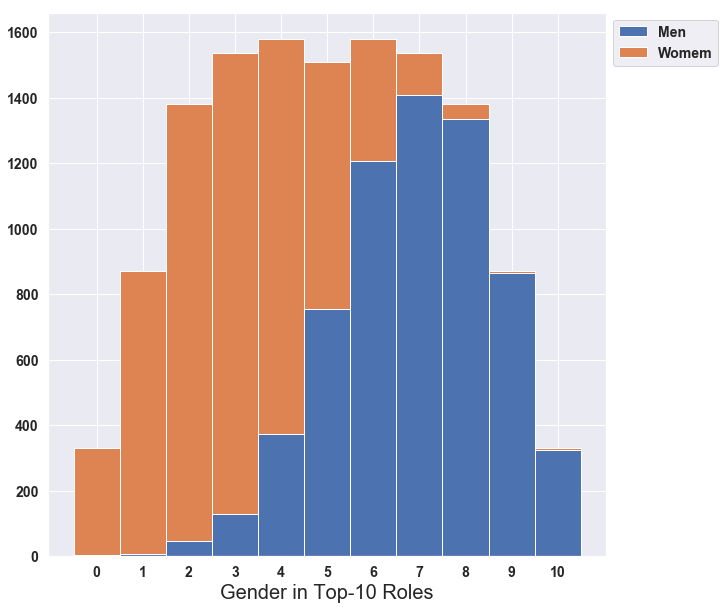

In [260]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
plt.figure(figsize=(10,10)) 

# y-axis in bold
rc('font', weight='bold')

# Values of each group
bars1 = hist_df["M"]
bars2 = hist_df["F"]
bars3 = [25, 3, 23, 25, 17]

# Heights of bars1 + bars2 (TO DO better)
bars = hist_df["M"] + hist_df["F"]

# The position of the bars on the x-axis
r = [0,1,2,3,4,5,6,7,8,9,10]

# Names of group and bar width
names = [0,1,2,3,4,5,6,7,8,9,10]
barWidth = 1

# Create brown bars
plt.bar(r, bars1,  edgecolor='white', width=barWidth, label="Men")
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1,  edgecolor='white', width=barWidth, label="Womem")
# Create green bars (top)
# plt.bar(r, bars3, bottom=bars, color='#2d7f5e', edgecolor='white', width=barWidth)

# Custom X axis
plt.xticks(r, names, fontweight='bold', size=14)
plt.yticks(size=14)

plt.xlabel("Gender in Top-10 Roles", size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':14})

# Show graphic
plt.show()


Text(0.5, 0, 'Women in Top-10 Roles')

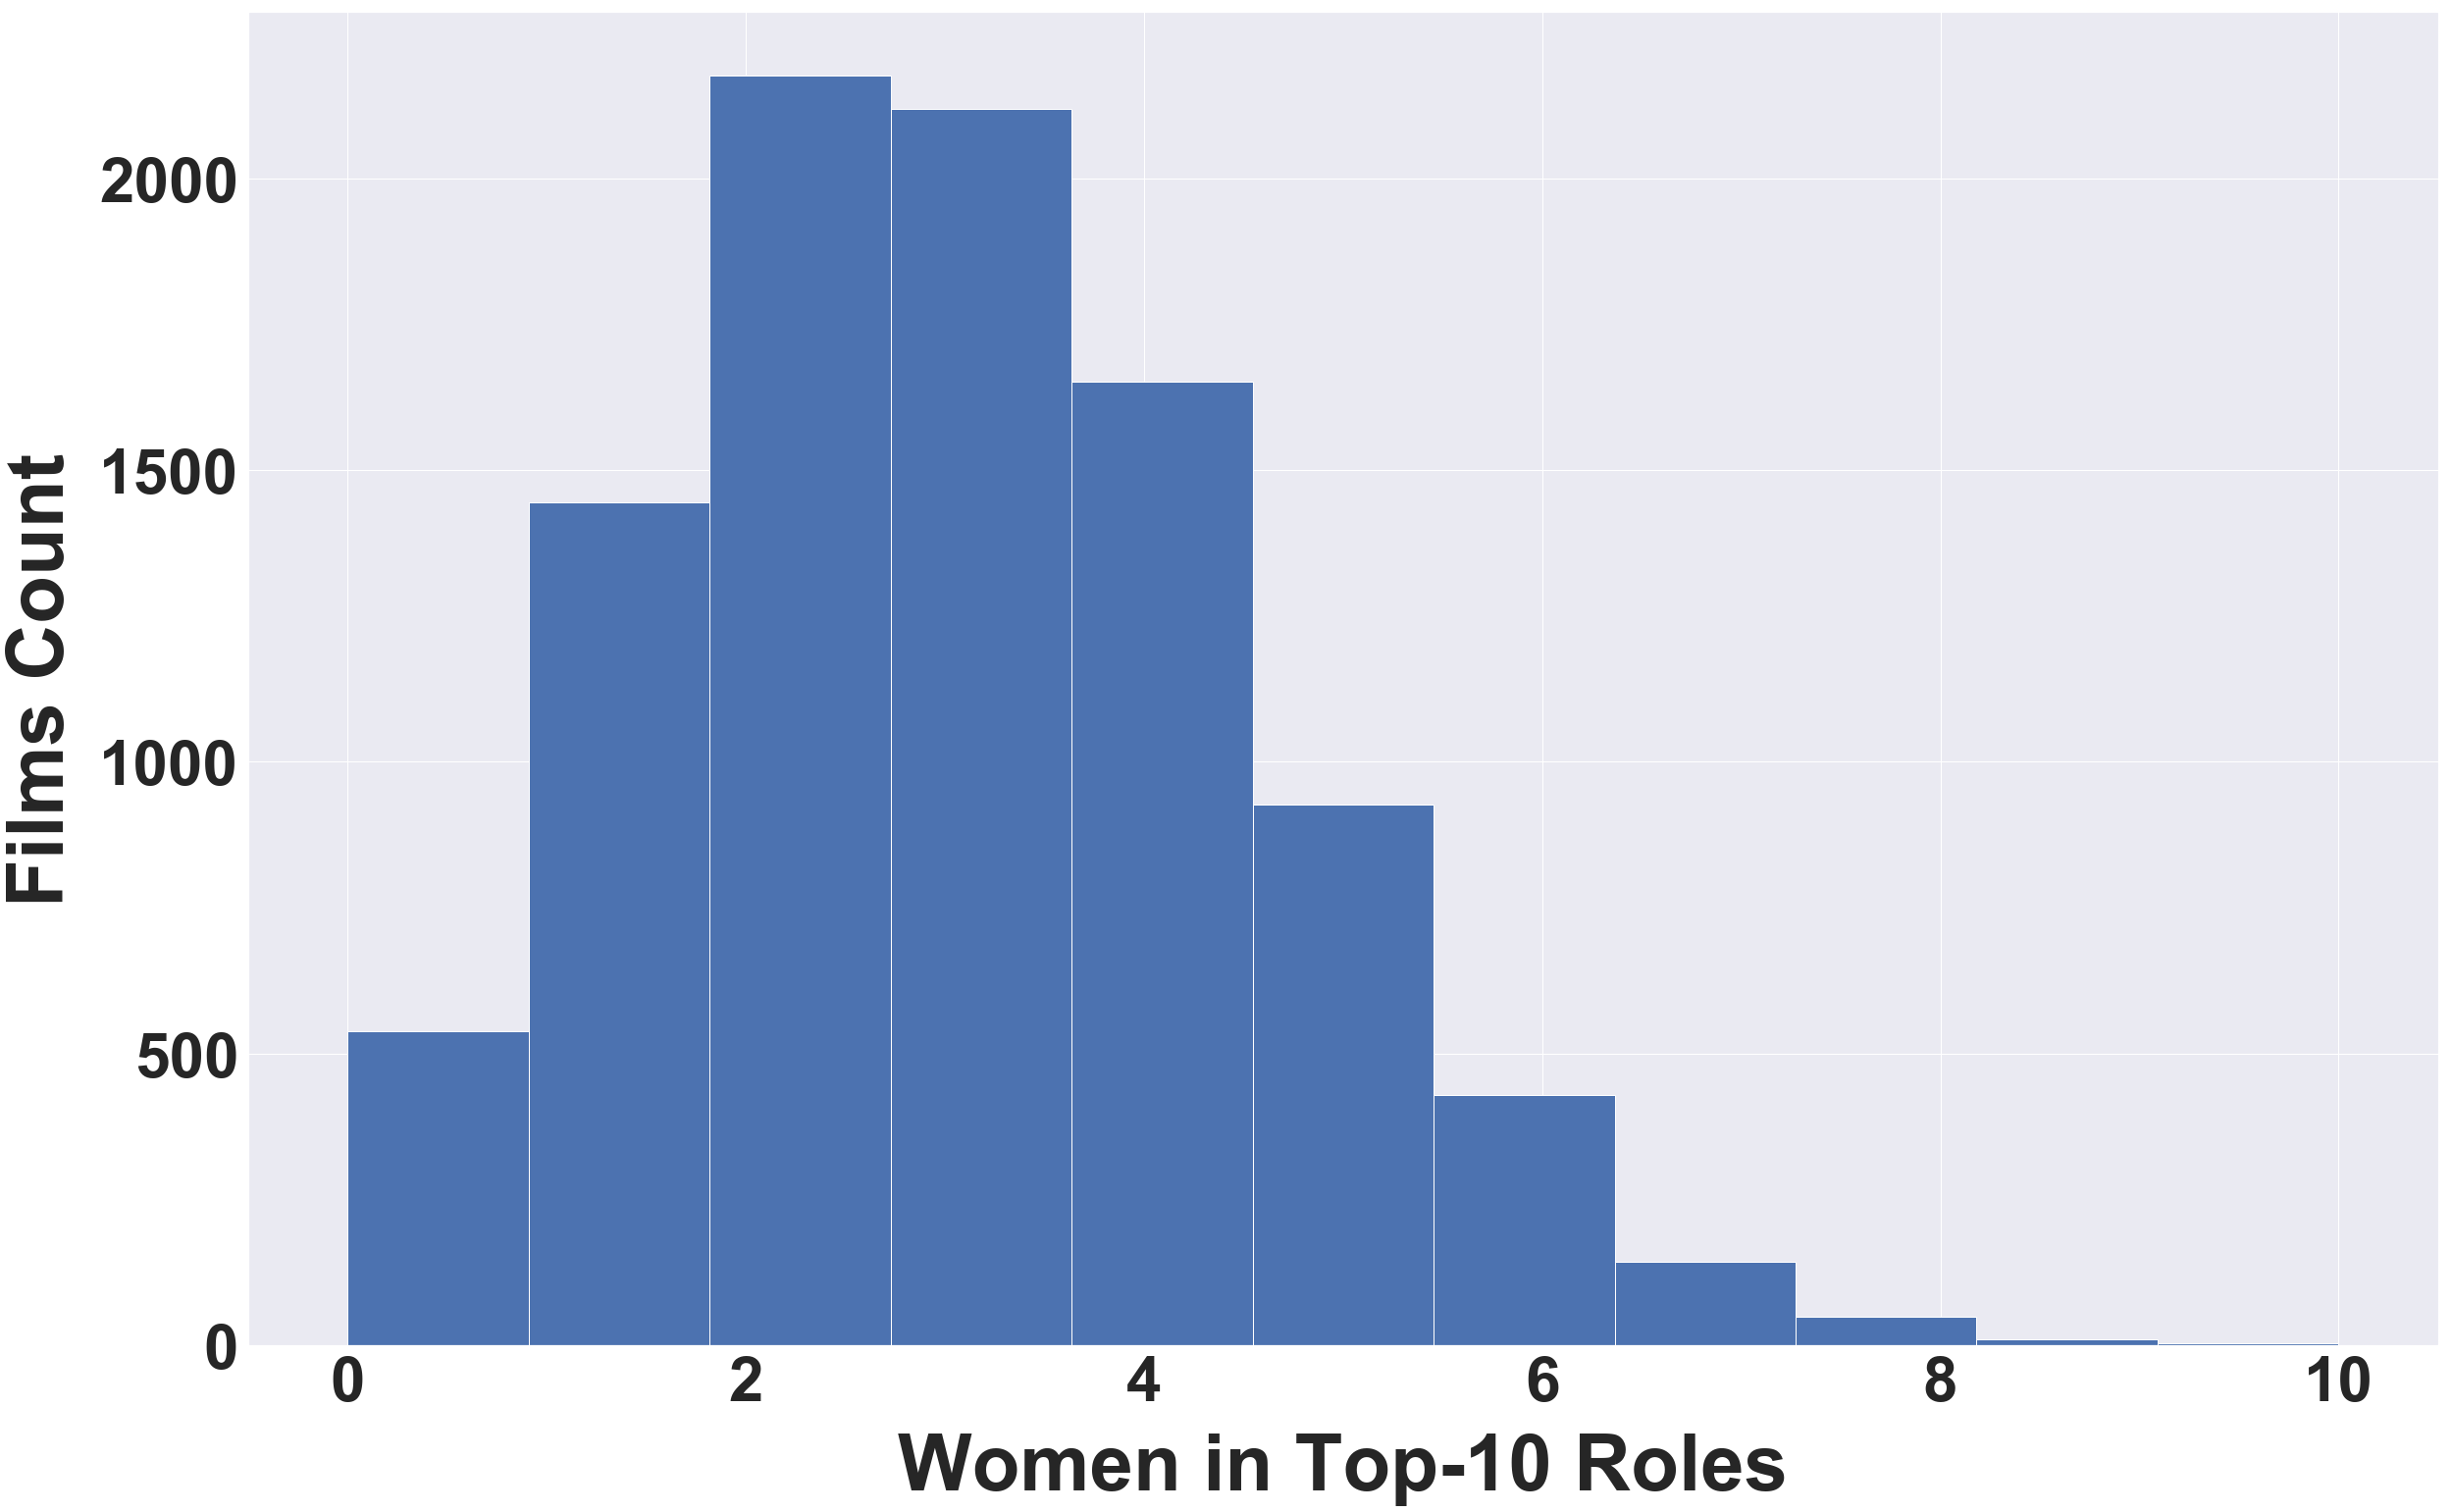

In [261]:
x = pager_gcentrality.groupby("movie_name").sum()["F"].hist(bins=11,figsize=(40, 25), ylabelsize=64, xlabelsize=64)

# Set x-axis label
x.set_ylabel("Films Count", labelpad=20, weight='bold', size=80)

# Set y-axis label
x.set_xlabel("Women in Top-10 Roles", labelpad=20, weight='bold', size=80)

Text(0.5, 0, 'Men in Top-10 Roles')

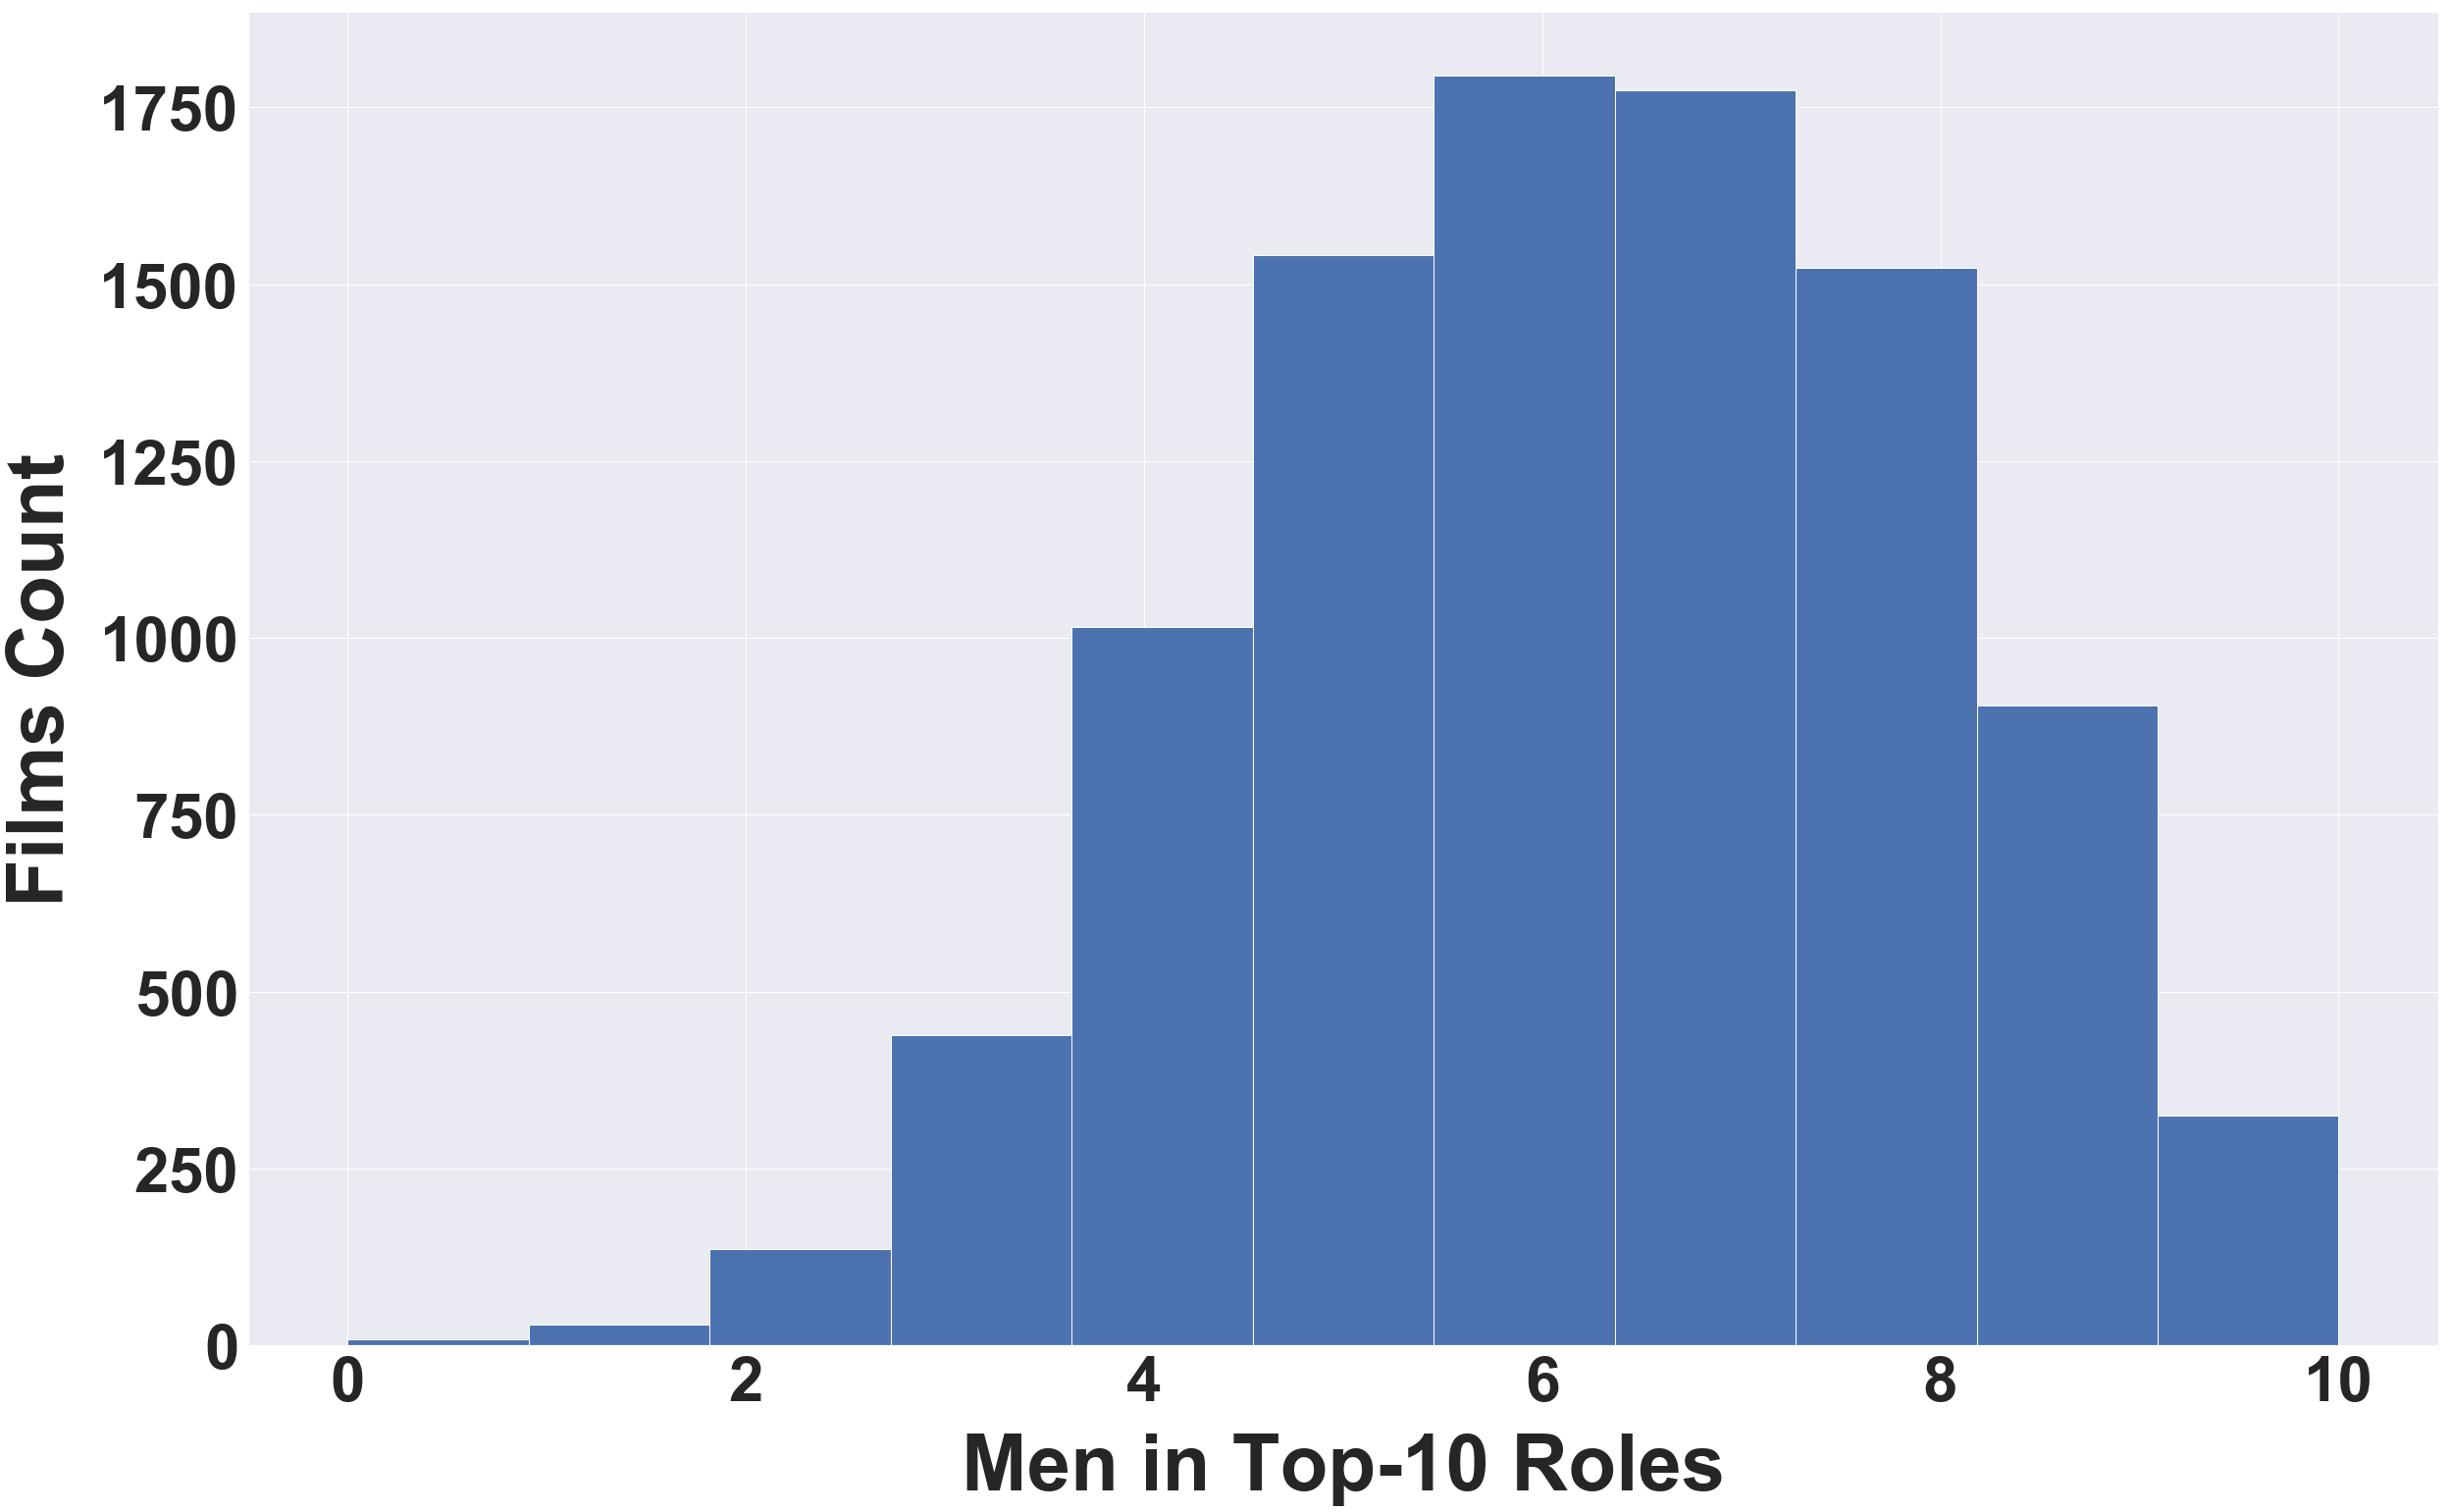

In [262]:
x = pager_gcentrality.groupby("movie_name").sum()["M"].hist(bins=11,figsize=(40, 25),ylabelsize=64, xlabelsize=64)
# Set x-axis label
x.set_ylabel("Films Count", labelpad=20, weight='bold', size=80)

# Set y-axis label
x.set_xlabel("Men in Top-10 Roles", labelpad=20, weight='bold', size=80)

In [263]:
m = pager_gcentrality.groupby("movie_name").sum()["M"].value_counts()

In [264]:
f = pager_gcentrality.groupby("movie_name").sum()["F"].value_counts()

In [265]:
f_overtime_temp = pager_gcentrality.groupby("movie_name").agg(['sum','count'])

In [266]:
f_overtime = pd.DataFrame()
f_overtime["F"] = f_overtime_temp["F"]["sum"]
f_overtime["year"] = f_overtime_temp["year"]["sum"]/f_overtime_temp["year"]["count"]

In [267]:
f_overtime[f_overtime["year"]==2018]["F"].describe()

count    161.000000
mean       3.285714
std        1.578878
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: F, dtype: float64

In [268]:
f_overtime.groupby("year").agg(["count","mean"]).tail(60)

F          
       count      mean
year                  
1959.0    41  2.804878
1960.0    44  2.863636
1961.0    36  2.750000
1962.0    43  2.604651
1963.0    44  2.818182
1964.0    46  2.847826
1965.0    37  2.054054
1966.0    35  2.457143
1967.0    41  2.585366
1968.0    43  2.511628
1969.0    27  2.444444
1970.0    43  2.488372
1971.0    54  2.611111
1972.0    43  2.162791
1973.0    48  2.458333
1974.0    48  2.708333
1975.0    43  2.581395
1976.0    47  2.553191
1977.0    42  2.976190
1978.0    58  2.568966
1979.0    56  2.500000
1980.0    66  2.454545
1981.0    69  2.347826
1982.0    74  2.864865
1983.0    65  2.615385
1984.0    79  2.455696
1985.0    92  2.923913
1986.0   100  2.620000
1987.0   105  2.990476
1988.0   116  3.103448
1989.0   102  2.598039
1990.0   103  2.524272
1991.0   108  2.787037
1992.0   126  2.753968
1993.0   139  2.748201
1994.0   146  2.732877
1995.0   143  3.062937
1996.0   159  2.723270
1997.0   165  2.781818
1998.0   169  2.982249
1999.0   173  3.046243
2000.0   186  2.854839
2001.0   206  2.970874
2002.0   216  2.819444
2003.0   208  2.860577
2004.0   225  3.044444
2005.0   245  3.032653
2006.0   276  2.894928
2007.0   302  3.099338
2008.0   316  3.066456
2009.0   331  3.120846
2010.0   318  2.889937
2011.0   334  3.020958
2012.0   359  2.949861
2013.0   384  2.890625
2014.0   391  3.046036
2015.0   315  3.117460
2016.0   343  3.090379
2017.0   262  3.278626
2018.0   161  3.285714

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


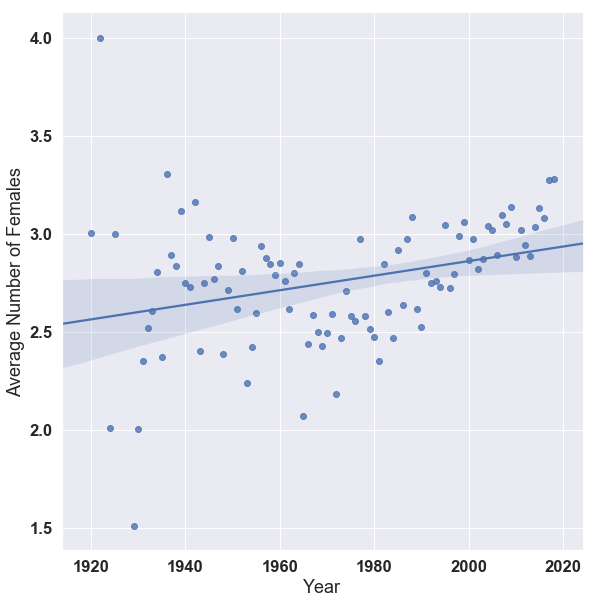

In [269]:
sea = f_overtime[["year", "F"]].groupby("year").mean()
sea["year"] = sea.index.values
# sea = sea[sea["year"] > 1950]
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.5) 

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="year", y="F", data=sea[["year","F"]],
               palette=pal, y_jitter=.02)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))
g.fig.set_size_inches(10,10)
g.set(xlabel='Year', ylabel='Average Number of Females')


### Bechdel

#### Data Downloading

In [485]:
import requests

r = requests.get("http://bechdeltest.com/api/v1/getAllMovies")

In [489]:
bechdel = r.json()

In [496]:
bechdel_df = pd.DataFrame(bechdel)

#### ML

In [185]:
from subs2graph.bechdel_classifier import BechdelClassifier

In [186]:
from turicreate import SFrame

In [187]:
graph_features = SFrame.read_csv("../temp/graph_features.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 100 lines in 0.101243 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 11421 lines in 0.09666 secs.

In [188]:
graph_features["year"].min()

1920

In [199]:
b = BechdelClassifier()
b.build_dataset()
# print(b.train_test())
rfc = b.train()
v = rfc.predict_proba(b.val)[:, 1]
print(v.mean())

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 100 lines in 0.033431 secs.

These column type hints were not used: X1

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 7871 lines in 0.011649 secs.

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel_features.csv

Parsing completed. Parsed 100 lines in 0.054754 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,int,float,int,float,float,float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,float,float,int,float,int,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,int,float,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,float,int,int,int,int,int,float,float,float,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel_features.csv

Parsing completed. Parsed 7922 lines in 0.044266 secs.

0.5689947513964758


In [200]:
b.dataset_to_csv("bechdel_train.csv")

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')  

f1_score(y_true, y_pred, average='micro')  

f1_score(y_true, y_pred, average='weighted')  

f1_score(y_true, y_pred, average=None)

In [190]:
bechdel_ml = b.bechdel_imdb
bechdel_ml = bechdel_ml[bechdel_ml["genres"] != None]
bechdel_ml = bechdel_ml.to_dataframe()
bechdel_ml["genres"] = bechdel_ml.genres.str.split(",")
for genre in set().union(*bechdel_ml.genres.values):
    bechdel_ml[genre] = bechdel_ml.apply(lambda _: int(genre in _.genres), axis=1)

In [191]:
bechdel_ml["rating"] = bechdel_ml["rating"] == 3

In [192]:
bechdel_ml

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,X1,...,Action,Adventure,Film-Noir,Romance,Short,Crime,Adult,Documentary,Comedy,Drama
0,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,None,4.0,"[Animation, Comedy, Romance]",1,...,0,0,0,1,0,0,0,0,1,0
1,tt0000012,short,The Arrival of a Train,L'arrivée d'un train à La Ciotat,0,1896.0,None,1.0,"[Documentary, Short]",4,...,0,0,0,0,1,0,0,1,0,0
2,tt0000014,short,Tables Turned on the Gardener,L'arroseur arrosé,0,1895.0,None,1.0,"[Comedy, Short]",2,...,0,0,0,0,1,0,0,0,1,0
3,tt0000091,short,The House of the Devil,Le manoir du diable,0,1896.0,None,3.0,"[Horror, Short]",7,...,0,0,0,0,1,0,0,0,0,0
4,tt0000131,short,A Terrible Night,Une nuit terrible,0,1896.0,None,1.0,"[Comedy, Horror, Short]",5,...,0,0,0,0,1,0,0,0,1,0
5,tt0000211,short,A Trip to the Moon,La lune à un mètre,0,1898.0,None,3.0,"[Comedy, Fantasy, Horror]",9,...,0,0,0,0,0,0,0,0,1,0
6,tt0000230,short,Cinderella,Cendrillon,0,1899.0,None,6.0,"[Drama, Fantasy, Short]",12,...,0,0,0,0,1,0,0,0,0,1
7,tt0000246,short,A Turn of the Century Illusionist,L'impressionniste fin de siècle,0,1899.0,None,1.0,[Short],11,...,0,0,0,0,1,0,0,0,0,0
8,tt0000272,short,As Seen Through a Telescope,As Seen Through a Telescope,0,1900.0,None,1.0,"[Comedy, Short]",13,...,0,0,0,0,1,0,0,0,1,0
9,tt0000300,short,The Enchanted Drawing,The Enchanted Drawing,0,1900.0,None,2.0,"[Animation, Comedy, Fantasy]",21,...,0,0,0,0,0,0,0,0,1,0


In [193]:
d = bechdel_ml.melt(["tconst","rating"],value_vars=genres).groupby(["rating", "variable"]).sum().reset_index().pivot(index='variable', columns='rating').reset_index()

In [194]:
clean_b = d.reset_index(level=None)["value"]
clean_b["genre"] = d["variable"]

In [146]:
clean_b = clean_b.rename(columns={True:"%", "genre":"Genre"})

In [150]:
clean_b["total"] = clean_b[True] + clean_b[False]

In [151]:
clean_b[True] = 100*clean_b[True]/clean_b["total"]

In [153]:
clean_b = clean_b.sort_values(True)

In [154]:
clean_b = clean_b.rename(columns={True:"%", "genre":"Genre"})

In [156]:
clean_b["total"] = 100

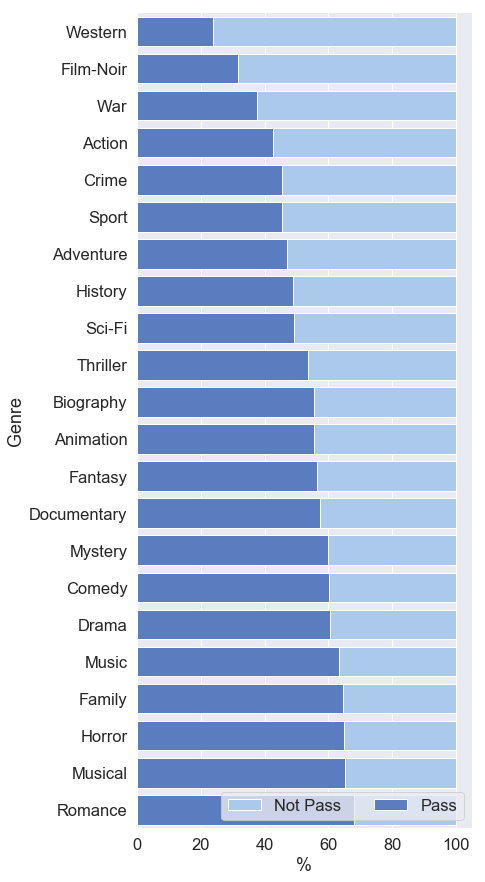

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(y="Genre", x="total", data=clean_b,
            label="Not Pass", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(y="Genre", x="%", data=clean_b,
            label="Pass", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#        xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
sns.set(font_scale=1.5)


In [166]:
b.val["decade"] = b.val["startYear"] // 10
b.val["decade"] = b.val["decade"] * 10

res_all = []
for y, d in b.val.groupby("decade"):
    if len(d) > 10 and y>0:
        d.pop("decade")
        v = rfc.predict_proba(d)[:, 1]
        print(y, v.mean(), len(d))
        res_all.append({"Decade": y, "Average Probabilty":v.mean()})

res = []
for g in genres:
#     print(f"{g}:")
    x = b.val.iloc[b.val[g].nonzero()]
    x = x[x["decade"] >1960]
    for y, d in x.groupby("decade"):
        if len(d) > 10:
            d.pop("decade")
            v = rfc.predict_proba(d)[:, 1]
#             print(y, v.mean(), len(d))
            res.append({"Genre":g, "Decade": y, "Average Probabilty":v.mean()})

1930 0.5559815221475686 99
1940 0.5723697680557085 175
1950 0.5254785980262296 209
1960 0.494646237992821 214
1970 0.5182316789870334 245
1980 0.5489352958768772 431
1990 0.5541099466417644 736
2000 0.5856667037496128 1208
2010 0.6003213787232777 1197


In [163]:
res_all

[{'Decade': 1930, 'Average Probabilty': 0.5559815221475685},
 {'Decade': 1940, 'Average Probabilty': 0.5723697680557085},
 {'Decade': 1950, 'Average Probabilty': 0.5254785980262296},
 {'Decade': 1960, 'Average Probabilty': 0.494646237992821},
 {'Decade': 1970, 'Average Probabilty': 0.5182316789870334},
 {'Decade': 1980, 'Average Probabilty': 0.5489352958768772},
 {'Decade': 1990, 'Average Probabilty': 0.5541099466417644},
 {'Decade': 2000, 'Average Probabilty': 0.5856667037496127},
 {'Decade': 2010, 'Average Probabilty': 0.6003213787232777}]

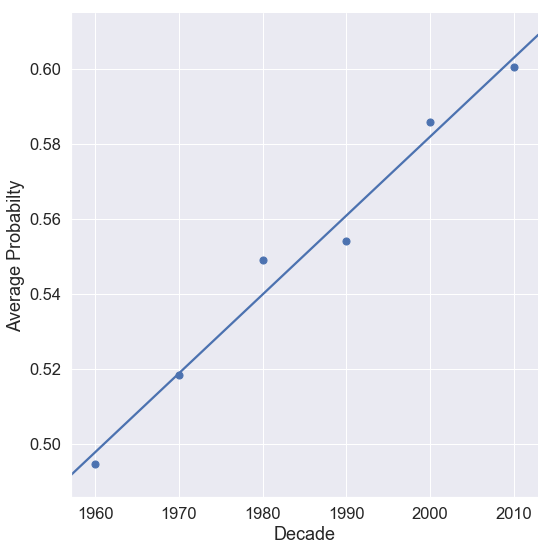

In [165]:
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
sns.lmplot(x="Decade", y="Average Probabilty", data=pd.DataFrame(res_all),
           ci=None, palette="muted", height=8,
           scatter_kws={"s": 50, "alpha": 1})

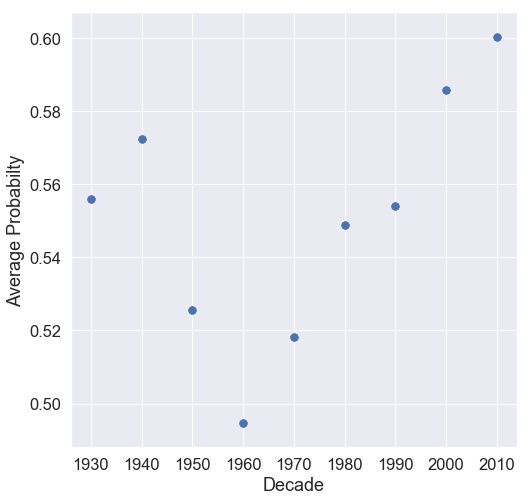

In [184]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})
sns.set(font_scale=1.5)
sns.scatterplot(x="Decade", y="Average Probabilty", data=pd.DataFrame(res_all),
           ci=None, palette="muted",s =90)

In [2137]:
df = pd.DataFrame(res)
df = df.sort_values("Genre")

In [2138]:
draw_genres = df.groupby("Genre").count().query("Decade==7").index

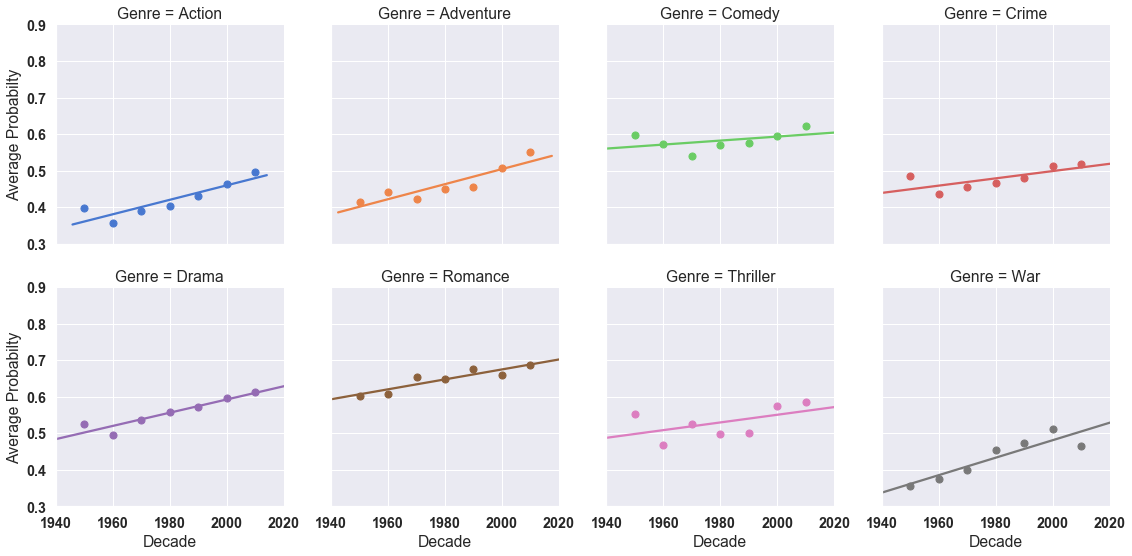

In [2163]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

# Load the example dataset for Anscombe's quartet

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="Decade", y="Average Probabilty", col="Genre", hue="Genre", data=df[df["Genre"].isin(draw_genres)],
           col_wrap=4, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
g.set(xlim=(1940, 2020), ylim=(0.3, 0.9))
g.fig.tight_layout(w_pad=1)


In [1713]:
from turicreate import SFrame

In [1714]:
bechdel = SFrame.read_csv("../data/bechdel.csv", column_type_hints={"imdbid": str})

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 100 lines in 0.05764 secs.

These column type hints were not used: X1

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/bechdel.csv

Parsing completed. Parsed 7871 lines in 0.037294 secs.

In [1715]:
bechdel.sort("year", False)

X1,id,imdbid,rating,title,year
7870,8423,0365545,3,Nappily Ever Aftet,2018
7869,8414,3829266,1,"Predator, The",2018
7868,8397,7282468,0,Burning,2018
7867,8385,3846674,3,To All the Boys I&#39;veLoved Before ...,2018
7866,8381,2231461,3,Rampage,2018
7865,8369,4779682,3,"Meg, The",2018
7864,8365,6791096,3,I Feel Pretty,2018
7863,8349,7279188,3,Woman at War,2018
7862,8345,7424200,3,Teen Titans Go! To theMovies ...,2018
7861,8337,6911608,3,Mamma Mia! Here We GoAgain ...,2018


In [1716]:
bechdel["tconst"] = "tt" + bechdel["imdbid"]

In [ ]:
triagles_gender

In [1720]:
bechdel_imdb = imdb_data.title.join(bechdel)

In [1724]:
bechdel_imdb = bechdel_imdb[bechdel_imdb["titleType"] == "movie"]

In [1721]:
triagles_gender["1"]= triagles_gender["X.0"]=="M"
triagles_gender["2"]= triagles_gender["X.1"]=="M"
triagles_gender["3"]= triagles_gender["X.2"]=="M"
triagles_gender["total"] = triagles_gender["1"] + triagles_gender["2"] + triagles_gender["3"]

In [1722]:
from turicreate import aggregate as agg
moive_triangle = triagles_gender.groupby(["tconst","total"], operations={'count': agg.COUNT()})
# type(moive_triangle)
traingles_at_movie = moive_triangle.to_dataframe().pivot_table(index=['tconst'], values ="count", columns='total', aggfunc= lambda x: x)
traingles_at_movie = traingles_at_movie.fillna(0)

In [1723]:
traingles_at_movie["tconst"] = traingles_at_movie.index.values

In [1725]:
bechdel_triangles = SFrame(traingles_at_movie).join(bechdel_imdb, {"tconst":"tconst"})

In [1726]:
graph_features = SFrame.read_csv("../temp/graph_features.csv")

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 100 lines in 0.080066 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int,int,float,int,str,int,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/graph_features.csv

Parsing completed. Parsed 11421 lines in 0.118676 secs.

In [1727]:
gender_centrality_movies = gender_centrality[gender_centrality["rank_pagerank"] < 11].groupby("movie_name").agg(["sum","count"])
gender_centrality_movies[["F", "year"]]["year"]
female_in_top_10 =  pd.DataFrame()
female_in_top_10["F_top10"] = gender_centrality_movies["F"]["sum"] / gender_centrality_movies["F"]["count"]
female_in_top_10["year"] = gender_centrality_movies["year"]["sum"] / gender_centrality_movies["year"]["count"]
female_in_top_10["movie_name"] = gender_centrality_movies.index.str.replace(" - roles", "")
female_in_top_10["year"] = female_in_top_10["year"].astype(int)

In [1728]:
graph_features = graph_features.join(SFrame(female_in_top_10), on={"movie_name":"movie_name", "year":"year"})

In [1729]:
graph_features = graph_features[graph_features["node_number"] > 5]

In [1730]:
bechdel_ml = graph_features.join(bechdel_triangles, on={"movie_name":"primaryTitle", "year":"year"})

In [1731]:
len(bechdel_ml)

3303

In [1732]:
bechdel_ml["rating"] = bechdel_ml["rating"] ==3

In [1733]:
bechdel_ml = bechdel_ml.to_dataframe()

In [1734]:
bechdel_ml["genres"] = bechdel_ml["genres"].apply(lambda x: x.split(","))

In [1735]:
for genre in set().union(*bechdel_ml.genres.values):
    bechdel_ml[genre] = bechdel_ml.apply(lambda _: int(genre in _.genres), axis=1)

In [1736]:
bechdel_ml.to_csv("bechdel_ml.csv", index=False)

In [1748]:
bechdel_ml = pd.DataFrame.from_csv("bechdel_ml.csv", index_col=None)

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [1758]:
bechdel_ml["titleType"].value_counts()

movie    3303
Name: titleType, dtype: int64

In [1738]:
bechdel_ml= bechdel_ml.sort_values("year")

In [1739]:
titles = bechdel_ml.pop('title')

In [1740]:
bechdel_ml = bechdel_ml.drop(["X1", "genres","imdbid" ,"originalTitle",'startYear', "movie_name",'endYear', 'isAdult', 'tconst', 'titleType',
       'id'], axis=1)

In [1741]:
bechdel_ml = bechdel_ml.fillna(0)

In [1742]:
np.any(np.isnan(bechdel_ml))

False

In [1743]:
bechdel_ml["total_tir"] = bechdel_ml["0"]+bechdel_ml["1"]+ bechdel_ml["2"]+ bechdel_ml["3"]
for i in range(4):
    bechdel_ml[f"{i}%"] = bechdel_ml[str(i)]/bechdel_ml["total_tir"]

In [1744]:
y = bechdel_ml.pop("rating")


In [1745]:
n_valid = 1000
X_valid, X_train  = split_vals(bechdel_ml, n_valid)
y_valid, y_train = split_vals(y, n_valid)

In [1746]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=5,  random_state=1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.46687959081872155, 0.5319774431308154, 0.7820234476769431, 0.717]


In [1747]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid, m.predict_proba(X_valid)[:, 1])

0.8035784189094842

In [894]:
import turicreate as tc
sf_train = SFrame(X_train)
sf_train["label"] = y_train
test_data = SFrame(X_valid)
test_data["label"] = y_valid

model = tc.boosted_trees_classifier.create(sf_train, target='label',
                                           max_iterations=30,step_size=0.1,
                                           max_depth = 4,column_subsample=0.5,validation_set=test_data, metric="auc")

# Save predictions to an SFrame (class and corresponding class-probabilities)
# predictions = model.classify(test_data)

# Evaluate the model and save the results into a dictionary
results = model.evaluate(test_data)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 2437

Number of classes           : 2

Number of feature columns   : 72

Number of unpacked features : 72

+-----------+--------------+---------------------------+-----------------------------+

| Iteration | Elapsed Time | Training Area Under Curve | Validation Area Under Curve |

+-----------+--------------+---------------------------+-----------------------------+

| 1         | 0.011038     | 0.811994                  | 0.779577                    |

| 2         | 0.016018     | 0.820160                  | 0.789547                    |

| 3         | 0.020311     | 0.827194                  | 0.792620                    |

| 4         | 0.024898     | 0.831697                  | 0.792758                    |

| 5         | 0.029757     | 0.836902                  | 0.795284                    |

| 10        | 0.052134     | 0.847713                  | 0.798919                    |

| 30        | 0.139005     | 0.876980                  | 0.800066                    |

+-----------+--------------+---------------------------+-----------------------------+

In [859]:
results

{'accuracy': 0.707, 'auc': 0.7880161066886383, 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  124  |
 |      1       |        1        |  425  |
 |      0       |        1        |  169  |
 |      0       |        0        |  282  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns], 'f1_score': 0.7436570428696413, 'log_loss': 0.5598957936782983, 'precision': 0.7154882154882155, 'recall': 0.7741347905282332, 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 549 | 451 |
 |   1e-05   | 1.0 | 1.0 | 549 | 451 |
 |   2e-05   | 1.0 | 1.0 | 549 | 451 |
 |   3e-05

In [835]:
def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) > 2:
        raise ValueError("Only supported for two relevance levels.")

    pos_label = unique_y[1]
    n_pos = np.sum(y_true == pos_label)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    print(len(y_true))
    n_relevant = np.sum(y_true == pos_label)

    # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
    return float(n_relevant) / min(n_pos, k)


In [836]:
import csv, os
from operator import itemgetter
from random import shuffle
from copy import deepcopy


class PrecisionKExtractor:
    def __init__(self, actual, predicted, probability):
        self._data = SFrame({"actual": actual, "predicted": predicted, "probability": probability})
        self._data = self._data.sort(["probability", "predicted"], ascending=False)


    def calculate_precision_k(self):
        k = float(1)
        current_sum = float(0)
        precision_k_list = []
        for n,row in enumerate(self._data):
            if row["predicted"] in [1, 0]:
                if row["actual"] == 1 and row["predicted"] ==1:
                    current_sum += 1
            precision_k_list.append([n+1, current_sum / self._data["predicted"][:n+1].sum()])
        return precision_k_list

probas  = m.predict_proba(X_valid)[:, 1]
prediction = np.where(probas > 0.5, 1, 0)
pke = PrecisionKExtractor(y_valid.values, prediction ,m.predict_proba(X_valid)[:, 1])
# pke.extract_batch(True)


In [837]:
debug = SFrame({"actual": y_valid.values, "predicted": prediction, "probability": m.predict_proba(X_valid)[:, 1], "title":split_vals(titles, n_valid)[0]})

In [838]:
patk = pke.calculate_precision_k()

In [839]:
patk[100]

[101, 0.9405940594059405]

In [1535]:
patk_df = pd.DataFrame(patk)
patk_df = patk_df.rename(columns={0:"K", 1: "Precision"})

In [1536]:
patk_df.columns

Index(['K', 'Precision'], dtype='object')

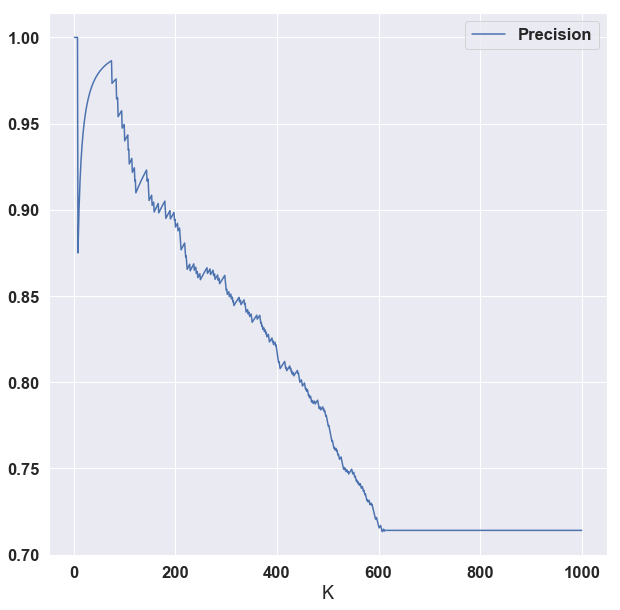

In [1537]:
patk_df.plot(0, 1, figsize=(10, 10))

In [918]:
debug = debug.sort("probability")

In [926]:
(debug[(debug["predicted"] ==0) & (debug["actual"] ==1) ])[0:]

actual,predicted,probability,title
1,0,0.24768081856614294,"China Syndrome, The"
1,0,0.2522618090324377,Advise &amp; Consent
1,0,0.2899268213747625,Hidden Agenda
1,0,0.2948506884292374,Inherit the Wind
1,0,0.2994037622604425,Hudson Hawk
1,0,0.3098054213711096,Polyester
1,0,0.3140809666280939,House of Games
1,0,0.3248747751196035,Street Fighter
1,0,0.3273504834708276,Bullets or Ballots
1,0,0.32772216664562426,Species


In [1567]:
(debug[(debug["predicted"] ==1) & (debug["actual"] ==0) ])[-10:]

actual,predicted,probability,title
0,1,0.8792432448796201,Three Faces of Eve
0,1,0.8831366990101179,Singles
0,1,0.8842371511857805,Terms of Endearment
0,1,0.8850489281339385,What About Bob?
0,1,0.8859819631223079,Radio Days
0,1,0.8870562364953188,Somewhere in Time
0,1,0.8902444900033426,Stella
0,1,0.8915309257628504,"Letter, The"
0,1,0.8953419959087949,10 Rillington Place
0,1,0.9276649425170711,Fanny and Alexander


In [842]:
debug[debug["title"] =='Net, The']

actual,predicted,probability,title
1,0,0.35326901958290746,"Net, The"


In [2147]:
rfc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [2151]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index=b.X_train.columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
3%,0.182496
1%,0.128906
1,0.092849
F_top10,0.081140
0%,0.070245
0,0.065061
f_count,0.063848
3,0.029751
2%,0.024189
Romance,0.010041


In [2150]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index=X_train.columns.values,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
3%,0.179843
F_top10,0.104309
1%,0.099907
0%,0.083919
0,0.060027
1,0.045920
f_count,0.040116
3,0.036637
2%,0.022212
Crime,0.012873


Confusion matrix, without normalization
[[280 172]
 [114 434]]
Normalized confusion matrix
[[0.62 0.38]
 [0.21 0.79]]


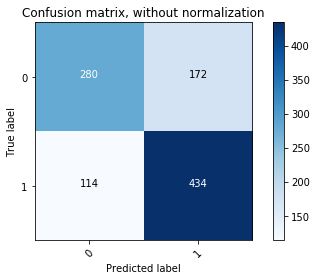

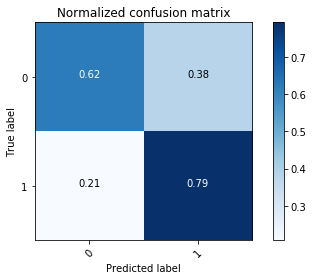

In [232]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = [0, 1]

y_pred = m.predict(X_valid)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, y_pred ,labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### T-test

#### Normality Tests

In [1004]:
from scipy.stats import ttest_ind, kstest

In [1081]:
x = np.linspace(-15, 15, 9)
loc, scale = 10, 1
s = np.random.exponential( scale, 10000)
kstest(df.birthYear, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

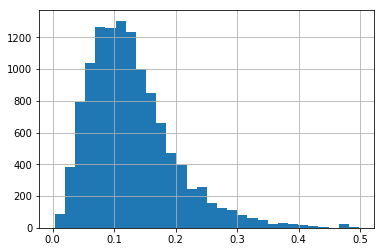

In [68]:
df.pagerank.hist(bins=30)

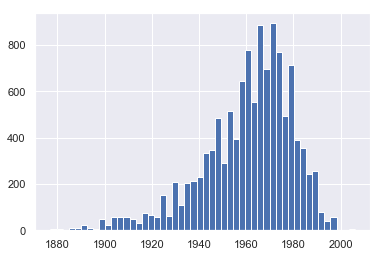

In [1079]:
df.birthYear.hist(bins=50)

In [1091]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(s)
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0.307157
The null hypothesis cannot be rejected


In [59]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(male.age_filming)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


By Gender:

#### Mann-Whitney U test

In [477]:
from scipy.stats import mannwhitneyu

def mannwhitney(data1, data2, alpha = 0.05):
    u_stat, p = mannwhitneyu(data1, data2)
    # print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    if p > alpha:
        return (p,u_stat,data1.median(),data2.median(), 'Same distribution (fail to reject H0)')
    else:
        return (p, u_stat,data1.median(),data2.median(),'Different distribution (reject H0)')

In [478]:
mwu = []
for col in df.columns.values:
    if "gender" not in col and df[col].dtype != object:
        mwu.append((col,*mannwhitney(male[col], female[col])))

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/scipy/stats/stats.py:4885: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  "`alternative` is deprecated.", DeprecationWarning)


In [479]:
import re

In [480]:
mwu = pd.DataFrame(mwu,columns=["Feature","p-value","U","Median(M)","Median(F)","Null"])

In [481]:
mwu["Feature"] = mwu.Feature.str.replace("_", " ")
mwu["Feature"] = mwu["Feature"].apply(lambda x: x.title())

In [482]:
mwu.to_csv("mwu.csv")

By genere:

In [483]:
mwu_g = []
for g in genres:
    if len(male[male[g] ==1]) >100 and len(female[female[g] ==1]) >100:
        print(g)
        for col in df.columns.values:
            if "gender" not in col and col not in genres and df[col].dtype != object:
                mwu_g.append((g, col,*mannwhitney(male[male[g] ==1][col], female[female[g] ==1][col])))

Family
Horror
Biography
Music
Mystery
Musical
Thriller
War
Sport
Fantasy
Animation
History
Sci-Fi
Action
Adventure
Film-Noir
Romance
Crime
Comedy
Drama


In [484]:
mwu_g = pd.DataFrame(mwu_g,columns=["Genre", "Feature","p-value","U","Median(M)","Median(F)","Null"])
mwu_g["Feature"] = mwu_g.Feature.str.replace("_", " ")
mwu_g["Feature"] = mwu_g["Feature"].apply(lambda x: x.title())

In [485]:
mwu_g.to_csv("mwu_g.csv")

## Tests

In [1232]:
len(glob.glob(os.path.join(TEMP_PATH, f"movies/*/json/*roles.json")))

13968

In [1218]:
imdb_data.actors[imdb_data.actors["primaryName"]=="Carrie-Anne Moss"]

Columns:
	nconst	str
	averageRating	float
	count	int
	primaryName	str
	birthYear	str
	deathYear	str
	primaryProfession	str
	knownForTitles	str
	gender	str

Rows: Unknown

Data:
+-----------+--------------------+-------+------------------+-----------+-----------+
|   nconst  |   averageRating    | count |   primaryName    | birthYear | deathYear |
+-----------+--------------------+-------+------------------+-----------+-----------+
| nm0005251 | 6.8199999999999985 |   15  | Carrie-Anne Moss |    1967   |     \N    |
+-----------+--------------------+-------+------------------+-----------+-----------+
+-------------------+-------------------------------+--------+
| primaryProfession |         knownForTitles        | gender |
+-------------------+-------------------------------+--------+
|  actress,producer | tt0133093,tt0209144,tt0457... |   F    |
+-------------------+-------------------------------+--------+
[? rows x 9 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [1223]:
t = SFrame.read_csv(f"{TEMP_PATH}/name.basics.tsv.gz", delimiter="\t",
                                                  na_values=["\\N"], nrows=100)

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 0.989886 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,int,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/name.basics.tsv.gz

Parsing completed. Parsed 100 lines in 0.667077 secs.

In [1231]:
t.stack("primaryProfession","primaryProfession")

nconst,primaryName,birthYear,deathYear,knownForTitles,primaryProfession
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",soundtrack
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",actor
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",miscellaneous
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",actress
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",soundtrack
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",actress
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",soundtrack
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",producer
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",actor
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",writer


In [1225]:
t["primaryProfession"] = t["primaryProfession"].apply(lambda x: x.split(","))
t.stack("primaryProfession","primaryProfession")

In [1295]:
imdb_data.all_actors["gender"].summary()


+------------------+---------+----------+
|       item       |  value  | is exact |
+------------------+---------+----------+
|      Length      | 3440575 |   Yes    |
| # Missing Values |    0    |   Yes    |
| # unique values  |    2    |    No    |
+------------------+---------+----------+

Most frequent items:
+-------+---------+
| value |  count  |
+-------+---------+
|   M   | 2161366 |
|   F   | 1279209 |
+-------+---------+


In [1374]:
pd.Series([10, 1,2,3,3, 4,5,6,7,8,9]).rank().astype(int)

0     11
1      1
2      2
3      3
4      3
5      5
6      6
7      7
8      8
9      9
10    10
dtype: int64

In [1365]:
pd.Series([1,2,3,3,3,4, 4,5,6,6,6,6,6,7,8,9]).rank().astype(int)

0      1
1      2
2      4
3      4
4      4
5      6
6      6
7      8
8     11
9     11
10    11
11    11
12    11
13    14
14    15
15    16
dtype: int64

###### Corrolations

In [162]:
female.corr()["age_filming"].sort_values()

birthYear              -0.593557
betweenness            -0.118554
degree_centrality      -0.105639
closeness              -0.098705
Action                 -0.066089
Adventure              -0.062448
Sci-Fi                 -0.060747
Horror                 -0.045146
cinematographer        -0.043658
total_weight           -0.031718
Music                  -0.031586
Fantasy                -0.029533
soundtrack             -0.028327
music_department       -0.028225
composer               -0.027123
director               -0.026245
Thriller               -0.025282
costume_designer       -0.023651
Family                 -0.022892
runtimeMinutes         -0.015810
Romance                -0.015804
Mystery                -0.014943
assistant_director     -0.014116
Sport                  -0.012541
Musical                -0.009829
Film-Noir              -0.009606
Crime                  -0.009007
miscellaneous          -0.008788
Western                -0.003204
casting_director       -0.003013
costume_de

In [163]:
male.corr()["age_filming"].sort_values()

birthYear              -0.958584
producer               -0.051052
degree_centrality      -0.046832
closeness              -0.041025
betweenness            -0.036253
degree                 -0.036160
total_weight           -0.029098
writer                 -0.023755
cinematographer        -0.018555
art_department         -0.015864
camera_department      -0.013812
editorial_department   -0.013516
Fantasy                -0.013271
Music                  -0.012800
Horror                 -0.011247
Sci-Fi                 -0.011221
assistant_director     -0.010835
War                    -0.009415
Adventure              -0.009130
Family                 -0.008221
executive              -0.007916
Film-Noir              -0.006199
Musical                -0.005560
production_manager     -0.004631
Action                 -0.004205
Documentary            -0.003242
director               -0.003231
sound_department       -0.002554
History                -0.002526
Romance                -0.001917
clustering

In [753]:
from sklearn.model_selection import LeaveOneGroupOut

X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


In [756]:
X = [1, 5, 10, 50, 60, 70, 80]
dy = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 1, 1, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s" % (train, test))

[4 5 6] [0 1 2 3]
[0 1 2 3] [4 5 6]


In [217]:
import spacy
%timeit  nlp_sm = spacy.load('en_core_web_sm')

463 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
import spacy
from spacy import displacy
%timeit  nlp_sm = spacy.load('en_core_web_sm')

doc2 = nlp("Welcome, Neo.")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp("As you no doubt have guessed...")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp("...I am Morpheus.")
displacy.render(doc2, style='ent', jupyter=True)

/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [177]:
import spacy
from spacy import displacy
nlp_md = spacy.load('en_core_web_md')

In [178]:
doc2 = nlp_md("You can see Tiger tonight. - Tiger?")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_md("As you no doubt have guessed...")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_md("...I am Morpheus.")
displacy.render(doc2, style='ent', jupyter=True)

/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [179]:
nlp_lg = spacy.load('en_core_web_lg')

In [181]:
import spacy
from spacy import displacy

doc2 = nlp_lg("My name is Tanaka. Please call me Tiger")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_lg("As you no doubt have guessed...")
displacy.render(doc2, style='ent', jupyter=True)

doc2 = nlp_lg("...I am Morpheus.")
displacy.render(doc2, style='ent', jupyter=True)

/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


/Users/dimakagan/miniconda3/envs/python3.6/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [269]:
imdb_data.all_actors

nconst,primaryName,birthYear,deathYear,knownForTitles,primaryProfession,gender
nm0000001,Fred Astaire,1899,1987,"tt0043044,tt0050419,tt0053137,tt0072308 ...",actor,M
nm0000002,Lauren Bacall,1924,2014,"tt0038355,tt0037382,tt0117057,tt0071877 ...",actress,F
nm0000003,Brigitte Bardot,1934,None,"tt0059956,tt0054452,tt0049189,tt0057345 ...",actress,F
nm0000004,John Belushi,1949,1982,"tt0072562,tt0077975,tt0078723,tt0080455 ...",actor,M
nm0000005,Ingmar Bergman,1918,2007,"tt0050976,tt0083922,tt0060827,tt0050986 ...",actor,M
nm0000006,Ingrid Bergman,1915,1982,"tt0071877,tt0034583,tt0038787,tt0038109 ...",actress,F
nm0000007,Humphrey Bogart,1899,1957,"tt0033870,tt0043265,tt0037382,tt0034583 ...",actor,M
nm0000008,Marlon Brando,1924,2004,"tt0068646,tt0070849,tt0047296,tt0078788 ...",actor,M
nm0000009,Richard Burton,1925,1984,"tt0087803,tt0061184,tt0057877,tt0059749 ...",actor,M
nm0000010,James Cagney,1899,1986,"tt0029870,tt0031867,tt0035575,tt0055256 ...",actor,M


In [53]:
imdb_data.title[imdb_data.title["primaryTitle"].apply(lambda x: 1 if "Bond" in x else 0)]

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes
tt0000539,short,Bonden i København,Bonden i København,0,1906,None,None
tt0001489,short,The Awakening of JohnBond ...,The Awakening of JohnBond ...,0,1911,None,None
tt0001511,short,Bondefangeri i Vaterland,Bondefangeri i Vaterland,0,1911,None,None
tt0003155,short,The Missing Bonds,The Missing Bonds,0,1913,None,None
tt0003396,short,A Soul in Bondage,A Soul in Bondage,0,1913,None,None
tt0004126,movie,The House of Bondage,The House of Bondage,0,1914,None,None
tt0004990,movie,Bondwomen,Bondwomen,0,1915,None,None
tt0005846,short,Out of Bondage,Out of Bondage,0,1915,None,20
tt0006458,movie,The Bondman,The Bondman,0,1916,None,None
tt0006587,movie,The Devil's Bondwoman,The Devil's Bondwoman,0,1916,None,None


Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 100 lines in 1.10157 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,str,str,str,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 1190442 lines. Lines per second: 823415

Read 9496862 lines. Lines per second: 1.35052e+06

Read 16520285 lines. Lines per second: 1.32832e+06

Read 23591041 lines. Lines per second: 1.31375e+06

Read 30700814 lines. Lines per second: 1.31527e+06

Finished parsing file /Users/dimakagan/Projects/subs2graph/temp/title.principals.tsv.gz

Parsing completed. Parsed 30924394 lines in 23.5009 secs.

tconst,ordering,nconst,category,job,X6
tt0000001,1,nm1588970,self,None,Herself
tt0000005,1,nm0443482,actor,None,Blacksmith
tt0000005,2,nm0653042,actor,None,Assistant
tt0000008,1,nm0653028,actor,None,Sneezing Man
tt0000009,1,nm0063086,actress,None,Miss Geraldine Holbrook(Miss Jerry) ...
tt0000009,2,nm0183823,actor,None,Mr. Hamilton
tt0000009,3,nm1309758,self,None,Himself - the Director ofthe New York Central ...
tt0000011,1,nm3692297,actor,None,Acrobats
tt0000012,1,nm2880396,self,None,Herself
tt0000012,2,nm9735580,self,None,Himself


In [14]:
james_bond = imdb_data.get_movies_by_character("James Bond")

In [152]:
james_bond_center = SFrame(gender_centrality).join(james_bond, on={"movie_name":"primaryTitle", "year":"startYear" })

In [153]:
james_bond_center

betweenness,betweenness_weight,closeness,clustering,degree,degree_centrality
0.6727272727272727,0.509090909090909,1.0,0.21818181818181814,11,1.0
0.0,0.07272727272727272,0.55,1.0,2,0.18181818181818185
0.0,0.07272727272727272,0.55,1.0,2,0.18181818181818185
0.027272727272727268,0.054545454545454536,0.6111111111111112,0.5,4,0.3636363636363637
0.0,0.0,0.55,1.0,2,0.18181818181818185
0.00909090909090909,0.09090909090909093,0.5789473684210527,0.6666666666666666,3,0.2727272727272727
0.054545454545454536,0.2363636363636364,0.6875,0.5333333333333333,6,0.5454545454545454
0.0,0.0,0.5789473684210527,1.0,3,0.2727272727272727
0.0,0.0,0.55,1.0,2,0.18181818181818185
0.01818181818181818,0.14545454545454545,0.6470588235294118,0.7,5,0.4545454545454546


In [151]:
gender_centrality["movie_name"] = gender_centrality["movie_name"].apply(lambda x: x.replace(" - roles", ""))

In [134]:
import turicreate.aggregate as agg


In [11]:
james_bond_center.groupby(["tconst","year"],{"M":agg.SUM("M"), "F":agg.SUM("F")}).sort("year").explore()

NameError: name 'james_bond_center' is not defined

In [155]:
james_bond_center["tconst","year"].unique()

tconst,year
tt0066995,1971
tt0093428,1987
tt0071807,1974
tt0090264,1985
tt0143145,1999
tt0381061,2006
tt0086006,1983
tt0120347,1997
tt0246460,2002
tt0086034,1983


In [84]:
from shutil import copyfile, rmtree

In [124]:
# movies = imdb_data.get_movies_by_title("Star Wars")
movies = imdb_data.get_movies_by_character("James Bond")

In [85]:
for m in movies:
    movie_name = m["primaryTitle"]
    if os.path.exists(f"{TEMP_PATH}/movies/{movie_name}/json/{movie_name} - roles.json"):
#         print(os.path.exists(f"{TEMP_PATH}/movies/{movie_name}/json/({m['startYear']}) - {movie_name}.png"))
        rmtree(f"{TEMP_PATH}/movies/{movie_name}")
#         copyfile(f"{TEMP_PATH}/movies/{movie_name}/json/{movie_name}.json", f"bond/d3/({m['startYear']}) - {movie_name}.json")

In [18]:
def draw_graph(g, outpath, graph_layout=nx.spring_layout):

    pos = graph_layout(g)
    plt.figure(num=None, figsize=(15, 15), dpi=150)
    plt.axis('off')


    d = dict(nx.degree(g))
    sorted_names = sorted(d.items(), key=lambda  v: (-v[1], v[0]))
    sorted_names = [n for n,v in sorted_names]
    g = g.subgraph(sorted_names)
    d = dict(nx.degree(g))

    
    gender = SFrame(list(g.nodes(data=True))).unpack('X1',  column_name_prefix="").unpack('1', column_name_prefix="")
    gender = gender.to_dataframe()
    gender= gender.set_index('0')
    gender=gender.reindex(g.nodes())
    gender['gender']=pd.Categorical(gender['gender'])
    
    edge_labels = dict([((u, v,), d['weight'])
                    for u, v, d in g.edges(data=True)])

    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
    
    nx.draw(g, pos, node_color=gender["gender"].cat.codes, edge_cmap=plt.cm.Reds, cmap=plt.cm.Set1 ,with_labels=True,  nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
    plt.savefig(outpath)
    plt.close()

In [24]:
from networkx.readwrite import json_graph
import glob

for g_json in glob.glob(f"bond/d3/*.json"):
    with open(g_json) as f:
        g = json_graph.node_link_graph(json.load(f))
        g_name = os.path.basename(g_json).split(".")[0]
        draw_graph(g,f"bond/{g_name}.png")
#         gender = SFrame(list(g.nodes(data=True))).unpack('X1',  column_name_prefix="").unpack('1', column_name_prefix="")

/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [16]:
movies = james_bond

In [23]:
for m in movies:
    movie_name = m["primaryTitle"]
    try:
        add_gender_to_graph(movie_name, False)
    except:
        pass

In [91]:
for m in movies.sort("startYear"):
    movie_name = m["primaryTitle"]
    print(f'<option value="({m["startYear"]}) - {movie_name}">{m["startYear"]}-{movie_name}</option>')

<option value="(1977) - Star Wars: Episode IV - A New Hope">1977-Star Wars: Episode IV - A New Hope</option>
<option value="(1980) - Star Wars: Episode V - The Empire Strikes Back">1980-Star Wars: Episode V - The Empire Strikes Back</option>
<option value="(1983) - Star Wars: Episode VI - Return of the Jedi">1983-Star Wars: Episode VI - Return of the Jedi</option>
<option value="(1999) - Star Wars: Episode I - The Phantom Menace">1999-Star Wars: Episode I - The Phantom Menace</option>
<option value="(2002) - Star Wars: Episode II - Attack of the Clones">2002-Star Wars: Episode II - Attack of the Clones</option>
<option value="(2005) - Star Wars: Episode III - Revenge of the Sith">2005-Star Wars: Episode III - Revenge of the Sith</option>
<option value="(2008) - Star Wars: The Clone Wars">2008-Star Wars: The Clone Wars</option>
<option value="(2015) - Star Wars: The Force Awakens">2015-Star Wars: The Force Awakens</option>
<option value="(2016) - Rogue One: A Star Wars Story">2016-Rogue

In [158]:
james_bond[""]

averageRating,numVotes,primaryTitle,startYear,tconst
6.8,341093,Spectre,2015,tt2379713
7.0,92556,Thunderball,1965,tt0059800
6.7,83937,Diamonds Are Forever,1971,tt0066995
7.7,154559,Goldfinger,1964,tt0058150
6.5,164461,Tomorrow Never Dies,1997,tt0120347
7.1,86710,The Spy Who Loved Me,1977,tt0076752
5.2,24412,Casino Royale,1967,tt0061452
7.3,130518,Dr. No,1962,tt0055928
6.6,83475,Licence to Kill,1989,tt0097742
8.0,525886,Casino Royale,2006,tt0381061


In [71]:
from fuzzywuzzy.fuzz import *
from fuzzywuzzy import process
from Levenshtein import ratio as lratio

In [77]:
{1:2,3:4}.keys()

dict_keys([1, 3])

In [25]:
partial_ratio("Don Vito Corlonee", "Vito Don")

75

In [74]:
lratio("Don", "Corlonee Vito Don")

0.3

In [98]:
WRatio("Don", "Don Jon")

0.6

In [75]:
None[0]

TypeError: 'NoneType' object is not subscriptable

In [87]:
choices = ["Don Vito Corleone", "Michael Corleone", "Michael"]
list(process.extractWithoutOrder("Don Corleone", choices))

[('Don Vito Corleone', 95), ('Michael Corleone', 76), ('Michael', 26)]

In [55]:
ratio("Dona Vitor", "Vito Don")

44

In [53]:
ratio("Don Vito", "Dona Vitor")

0.8888888888888888

In [47]:
set(full_process("Dona Vitor").split())

{'dona', 'vitor'}

In [8]:
from subs2graph.video_roles_analyzer import tmdb
tmdb.API_KEY = os.getenv('TMD_API_KEY')


/Users/dimakagan/Projects/subs2graph/subs2graph/video_roles_analyzer.py:79: DeprecationWarning: invalid escape sequence \w
  re_possessive = re.compile("(\w+\'s\s+\w+|\w+s\'\s+\w+)")
/Users/dimakagan/.local/share/virtualenvs/subs2graph-1tJturt5/lib/python3.6/site-packages/dogpile/cache/util.py:31: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(fn)


In [9]:
external_source = 'imdb_id'
find = tmdb.Find("tt2379713")
resp = find.info(external_source=external_source)
m_id = resp['movie_results'][0]['id']
m = tmdb.Movies(m_id)

for person in m.credits()['cast']:
    if not "uncredited" in person['character']:
        print(f"{person['order']} {person['id']} {person['name']}| {person['character']}| {person['profile_path']}")

0 8784 Daniel Craig| James Bond| /mr6cdu6lLRscfFUv8onVWZqaRdZ.jpg
1 27319 Christoph Waltz| Ernst Stavro Blofeld| /2Hhztd4mUEV9Y25rfkXDwzL9QI9.jpg
2 121529 Léa Seydoux| Dr. Madeleine Swann| /xptyFXfBENBMQkgPEYCxlMkSLSs.jpg
3 5469 Ralph Fiennes| Gareth Mallory / M| /d2vvUY7bzEbNRXInVVwuyHkN6Bz.jpg
4 28782 Monica Bellucci| Lucia Sciarra| /nkrIGojQy6FNn9s5cfpiUAmLeNz.jpg
5 17064 Ben Whishaw| Q| /e74Cz65ifeNb9zHfUTvF5rTix0d.jpg
6 2038 Naomie Harris| Eve Moneypenny| /41TVAcYqKKF7PGf3x7QfaLvkLSW.jpg
7 543530 Dave Bautista| Mr. Hinx| /oZDL1VprkUEFhOtG5WcVjudj5ks.jpg
8 125660 Andrew Scott| Max Denbigh / C| /3yu4zC3OVq2lvmMqnPT4RYH4sBU.jpg
9 139549 Rory Kinnear| Tanner| /x6S1iZAHHjtPCCyYKOVMOea6zbU.jpg
10 2244 Jesper Christensen| Mr. White| /fnE1D2BtNex0bUZE4DdxAsju0YR.jpg
11 1381616 Alessandro Cremona| Marco Sciarra| /qhJDXXELVYFIl5wBCuWjznL1Xk6.jpg
12 929937 Stephanie Sigman| Estrella| /9ZOVeNIGXziOXBSDNu60pvzuKrs.jpg
13 87265 Tenoch Huerta| Mexican Man in Lift| /3wGFejGaiDp65z4CrDZaItsPKgC.jp

In [116]:
person

{'cast_id': 64,
 'character': 'Police (uncredited)',
 'credit_id': '58d8007ac3a368125f058021',
 'gender': 0,
 'id': 1784215,
 'name': 'Bedri Çavusoglu',
 'order': 44,
 'profile_path': None}

In [22]:
from itertools import combinations
list(combinations(["x"],1))

[('x',)]

In [208]:
graph_features.column_names

<bound method SFrame.column_names of Columns:
	appearance-25%	float
	appearance-50%	float
	appearance-75%	float
	appearance-max	float
	appearance-mean	float
	appearance-min	float
	appearance-std	float
	average_clustering	float
	average_weighted_clustering	float
	betweenness-25%	float
	betweenness-50%	float
	betweenness-75%	float
	betweenness-max	float
	betweenness-mean	float
	betweenness-min	float
	betweenness-std	float
	clique_number	int
	closeness-25%	float
	closeness-50%	float
	closeness-75%	float
	closeness-max	float
	closeness-mean	float
	closeness-min	float
	closeness-std	float
	degree-25%	float
	degree-50%	float
	degree-75%	float
	degree-max	float
	degree-mean	float
	degree-min	float
	degree-std	float
	edge_number	int
	f_count	int
	imdb_rating	float
	m_count	int
	movie_name	str
	node_number	int
	pagerank-25%	float
	pagerank-50%	float
	pagerank-75%	float
	pagerank-max	float
	pagerank-mean	float
	pagerank-min	float
	pagerank-std	float
	weight-25%	float
	weight-50%	float
	weight-75

In [210]:
graphs_meta= graph_features[["average_clustering","movie_name","year","node_number","edge_number","weight-mean"]]

In [205]:
datavers = SFrame.read_csv(f"{DATA_PATH}/dataverse_files/network_metadata.tsv",delimiter='\t')

Finished parsing file /Users/dimakagan/Projects/subs2graph/data/dataverse_files/network_metadata.tsv

Parsing completed. Parsed 100 lines in 0.02902 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,str,str,str,str,str,str,str,str,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/dimakagan/Projects/subs2graph/data/dataverse_files/network_metadata.tsv

Parsing completed. Parsed 773 lines in 0.007317 secs.

In [212]:
comp = datavers.join(graphs_meta,{"ReleaseDate":"year","Title":"movie_name"})

In [215]:
comp.sort("edge_number", False)

GexfID,Title,IMDB_id,ReleaseDate,Slug,WeightedDegree,Modularity
456,JFK,tt0102138,1991,JFK,"7,256","0,480"
523,Magnolia,tt0175880,1999,Magnolia,"8,022","0,663"
356,The Godfather: Part II,tt0071562,1974,The-Godfather:-Part-II,"6,903","0,516"
178,Casino,tt0112641,1995,Casino,"9,628","0,415"
659,Public Enemies,tt1152836,2009,Public-Enemies,"6,929","0,453"
355,The Godfather,tt0068646,1972,The-Godfather,"8,476","0,329"
52,American Gangster,tt0765429,2007,American-Gangster,"5,031","0,418"
509,Lone Star,tt0116905,1996,Lone-Star,"6,453","0,458"
715,Scream 3,tt0134084,2000,Scream-3,"11,548","0,229"
586,Nashville,tt0073440,1975,Nashville,"9,073","0,359"


In [216]:
len(imdb_data.rating[imdb_data.rating["numVotes"] > 5000])

14237

In [229]:
sorted([(f, os.path.getmtime(f"{TEMP_PATH}/movies/{f}")) for f in os.listdir(f"{TEMP_PATH}/movies/")],key=lambda x: x[1])

[('Pariyerum Perumal', 1550387781.911832),
 ('Yowis Ben', 1550387778.0534527),
 ('Maya Bazaar', 1550387777.966828),
 ('CM101MMXI Fundamentals', 1550387758.6164668),
 ('The Shawshank Redemption', 1550387743.0747824),
 ('Co Kancharapalem', 1550387725.616148),
 ('The Chaos Class', 1550387725.5236688),
 ('Jibon Thekey Neya', 1550387698.2933965),
 ('Ekvtime: Man of God', 1550387695.1593575),
 ('The Phantom of the Opera at the Royal Albert Hall', 1550048113.353198),
 ('Anand', 1549995906.7254508),
 ('Aloko Udapadi', 1549995585.546239),
 ('.DS_Store', 1549969488.6791859),
 ('The Imitation Game ', 1549969488.5983143),
 ('The Imitation Game', 1549969319.430111),
 ('Skyfall', 1549531726.4086592),
 ('Tomorrow Never Dies', 1549462739.035542),
 ('Star Wars: Episode V - The Empire Strikes Back', 1549446761.0762215),
 ('Star Wars: The Clone Wars', 1549446736.1868489),
 ('Star Wars: The Force Awakens', 1549446693.2223742),
 ('Star Wars: Episode VI - Return of the Jedi', 1549446669.4847941),
 ('Star Wa

In [230]:
!ls -lt ../temp/movies/ | head -10

total 0
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:16 Pariyerum Perumal
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:16 Yowis Ben
drwxr-xr-x   7 dimakagan  staff  224 Feb 17 09:16 Maya Bazaar
drwxr-xr-x   7 dimakagan  staff  224 Feb 17 09:15 CM101MMXI Fundamentals
drwxr-xr-x   9 dimakagan  staff  288 Feb 17 09:15 The Shawshank Redemption
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:15 Co Kancharapalem
drwxr-xr-x   7 dimakagan  staff  224 Feb 17 09:15 The Chaos Class
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:14 Jibon Thekey Neya
drwxr-xr-x   6 dimakagan  staff  192 Feb 17 09:14 Ekvtime: Man of God
